# Predict the value of football players using their Fifa statistics

**12th October 2019**

- Is it possible to predict the value of a football player given information about their playing strengths, weaknesses and playing position?  
- Can we identify players which are under or over valued compared to the market?
- What features are most important for determining the value of a player?


### Purpose of the notebook
- practice at conventional and ml regression techniques
- EDA, modelling and model interpretation using SHAP values

In this notebook I will use a dataset of player attributes curated from the SOFIFA.com website (scrapy crawler to collect the data is located in the *data_collection* folder in the repository) to gain an insight into the factors driving the value of football players. 

I will carry out some basic EDA analysis to gain a high level overview of the features in the dataset, before preparing the data for modelling (data cleaning; train/test split; scaling etc..) and trying out different regression models to predict the value of football players in the dataset. Finally, I will carry out some model tuning to select the best model and interpret the feature importances which will give insights into which are the most important factors for determining the value of a player.

## Executive Summary

Player attribute scores (e.g. passing, accuracy, stamina, acceleration etc.) and additional information (e.g. age, position, potential etc.) was collected from the SoFIFA website for the 2019 season. This information was used to develop a model to predict the value of each player. The target variable, 'value' was log transformed...................predict the   The distribution of football player values is very positively skewed with most players having relatively low valuations, but with a few exceptional players commanding a significant premium.


## Exploratory Data Analysis

EDA and initial feature cleaning/creation.


#### EDA Imports

In [1]:
#data manipulation
import pandas as pd
import numpy as np 
pd.options.display.max_columns = 999

#stats
from scipy.stats import pearsonr

#viz
import matplotlib.pyplot as plt
import seaborn as sns

#other
import missingno as msno
from IPython.core.display import display, HTML

#list of player attributes (e.g passing accuracy, acceleration etc.)
from const import ATTRIBUTES

In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Load data

- Load the processed clean dataset for the "1. Processed" folder. 
- Remove the redundant columns for name/link/id etc. 
- keep columns with features we want for modelling
    - For this exercise we will not use the players' wages as a feature as it is likely directly correlated with 'value', therefore if you know the wage of the player it is not difficult to estimate the value. It is more useful to just use playing attributes (along with age and position) to assess the value of the player as that will enable us to draw inferences about which playing attributes are perceived as more valuable.
    
All player attributes are ranked from 1 to 100.

In [3]:
raw_df = pd.read_csv("data/1. processed/data_clean.csv")

df = raw_df.loc[raw_df['value_clean']!=0].copy() #delete rows with 0 in value_clean column

#select sensible features
df = df[ATTRIBUTES + ['age','overall_rating','potential','Position','value_clean']].copy()

display(HTML('<br><b>First five rows of the dataset:</b>'))
display(df.head())
print(f"Total number of rows: {df.shape[0]}\nTotal number of columns: {df.shape[1]}")

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,age,overall_rating,potential,Position,value_clean
0,47,39,71,72,21,59,32,28,66,64,73,85,61,67,62,44,86,61,88,24,81,75,35,56,39,68,68,84,75,6,7,8,15,9,19,77,88,LCB,13000000.0
1,60,65,64,76,68,77,59,68,70,77,79,77,76,72,90,85,79,86,76,77,90,69,70,67,68,68,73,70,64,5,12,6,13,14,20,75,84,CM,10000000.0
2,41,43,74,73,43,68,41,47,53,73,71,71,72,73,72,56,72,65,71,39,61,74,46,52,47,57,73,76,72,8,15,7,14,9,20,74,85,CB,8500000.0
3,18,19,17,25,15,14,22,18,29,25,49,54,69,65,65,25,75,39,51,20,23,17,15,66,23,45,25,16,21,73,70,69,74,77,20,73,87,GK,7500000.0
4,72,69,54,90,90,90,85,77,87,90,78,69,90,86,86,76,75,75,59,79,56,78,79,86,75,85,67,67,71,6,11,7,9,13,27,87,87,CM,51500000.0


Total number of rows: 13758
Total number of columns: 39


#### Check for missing data

Crossing             0
Finishing            0
Heading Accuracy     0
Short Passing        0
Volleys              0
Dribbling            0
Curve                0
FK Accuracy          0
Long Passing         0
Ball Control         0
Acceleration         0
Sprint Speed         0
Agility              0
Reactions            0
Balance              0
Shot Power           0
Jumping              0
Stamina              0
Strength             0
Long Shots           0
Aggression           0
Interceptions        0
Positioning          0
Vision               0
Penalties            0
Composure            0
Marking              0
Standing Tackle      0
Sliding Tackle       0
GK Diving            0
GK Handling          0
GK Kicking           0
GK Positioning       0
GK Reflexes          0
age                  0
overall_rating       0
potential            0
Position            39
value_clean          0
dtype: int64

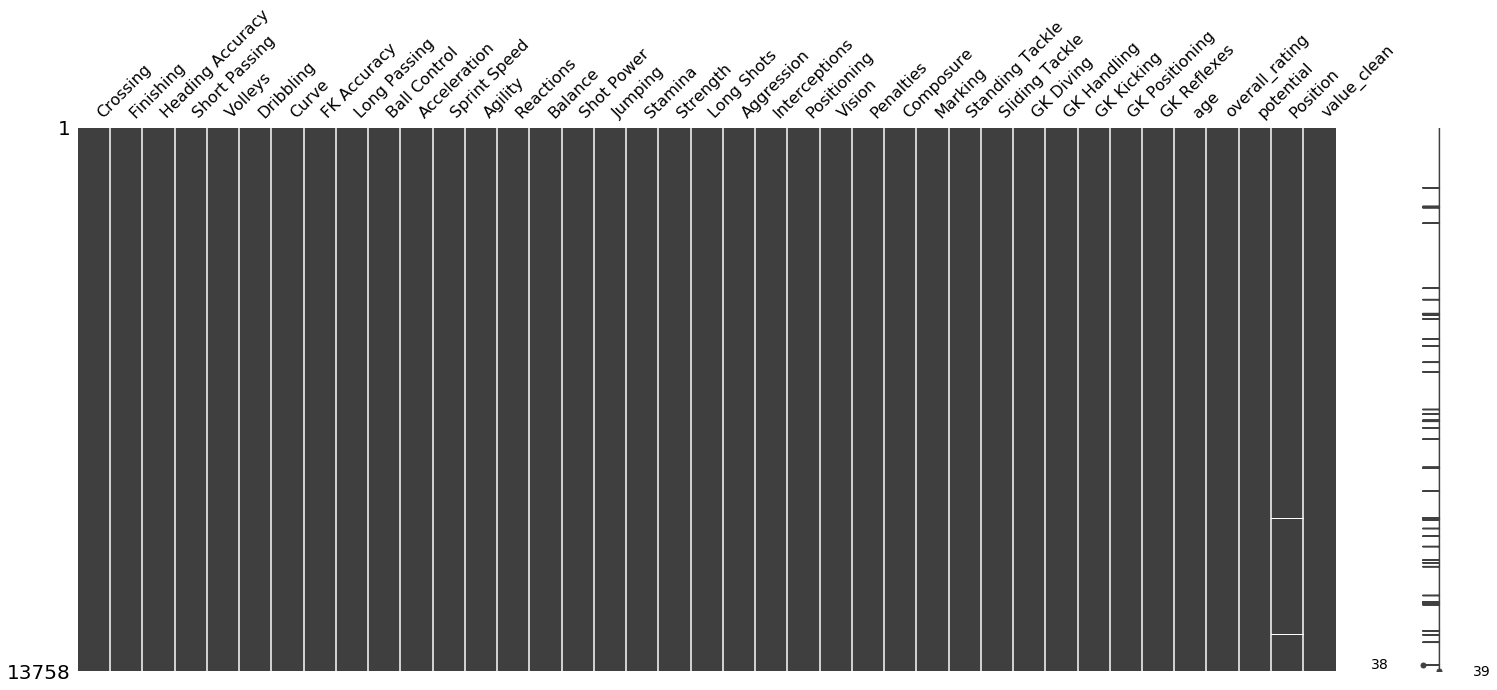

In [4]:
display(df.isnull().sum())

msno.matrix(df)
plt.show()

The 'position' feature which contains the position of the player has 39 missing datapoints. As this is only a very small subset of the total data (~13,800 total data points) I will just drop these datapoints.

In [5]:
#drop missing datapoints
df = df.loc[df['Position'].notnull()].copy()

### Feature Analysis

#### value_clean (target variable)

The value_clean column contains the value of each player in &euro;.

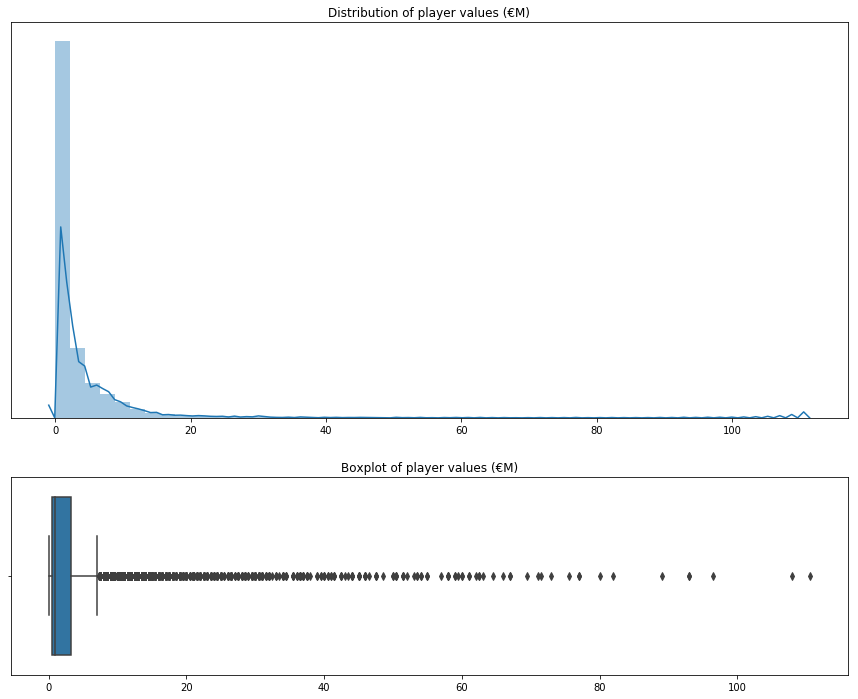

,value_clean
count,13719.000000
mean,3.163104
std,6.367481
min,0.010000
25%,0.475000
50%,0.950000
75%,3.200000
max,110.500000


In [6]:
def plot_distribution_and_stats(feature,name):
    """Helper function to plot distribution charts"""
    
    fig, ax = plt.subplots(nrows=2,figsize=(15,12),gridspec_kw={'height_ratios': [2, 1]})
    sns.distplot(feature,ax=ax[0])
    ax[0].set_title(f"Distribution of {name}")
    ax[0].set_yticks([])
    
    sns.boxplot(feature, ax=ax[1])
    ax[1].set_title(f"Boxplot of {name}")
    plt.show()
    
    display(feature.describe())
    
plot_distribution_and_stats(df[['value_clean']]/1_000_000,'player values (\N{euro sign}M)')

The player value is our target feature. The values of different players varies significantly, particularly for the top players whose value increases exponentially. The distribution shows that the variable is very positively skewed which could make prediction of very high value players difficult during modelling. 

The highest value player is &euro;110M and the lowest value player is just &euro;10,000. The mean is approximately &euro;3M but with a very large standard deviation of &euro;6M.

Due to these unfavorable distribution statistics, it will be a good idea to apply a log transformation on the data to reduce the variance in the target variable.

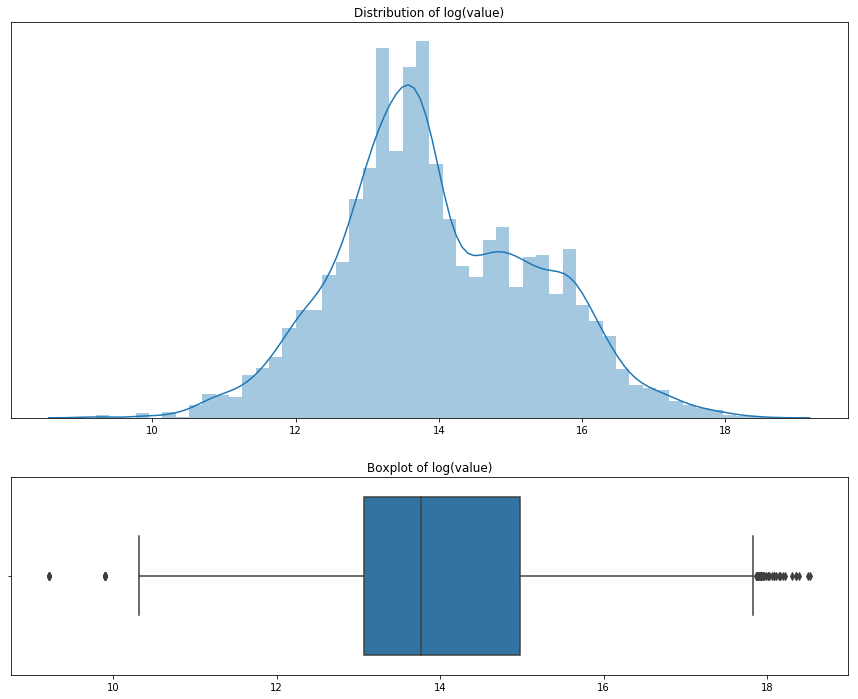

,value_clean_log
count,13719.000000
mean,13.974646
std,1.387843
min,9.210340
25%,13.071070
50%,13.764217
75%,14.978661
max,18.520526


In [7]:
#create log transformation
df['value_clean_log'] = np.log(df['value_clean'])

plot_distribution_and_stats(df[['value_clean_log']],'log(value)')

The target variable now looks more normally distributed and has a much lower standard deviation compared to the mean.

The box plot shows that most of the data is within the interquartile range with a few outliers at the top and bottom ends.

#### Age

The age of each player.

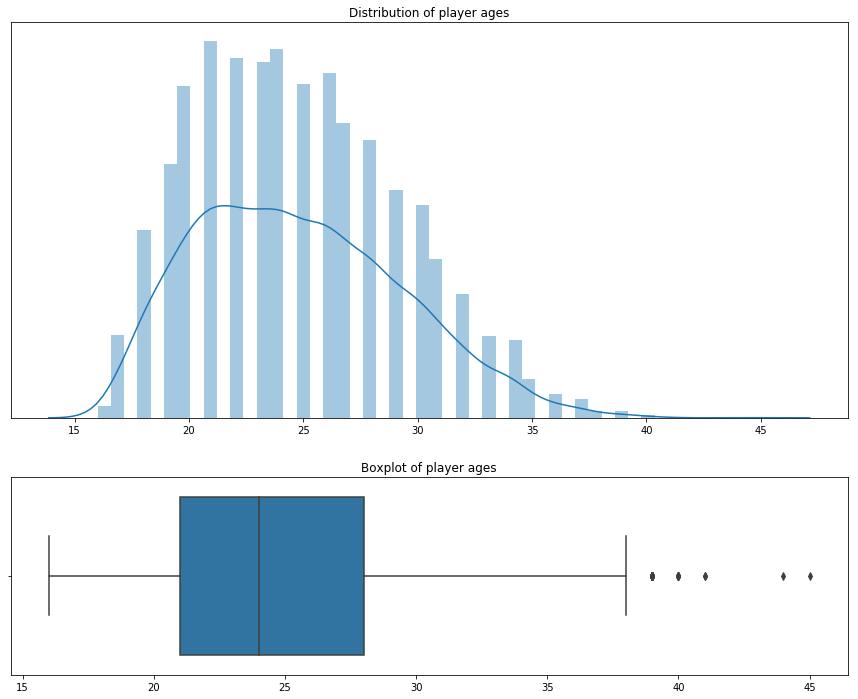

,age
count,13719.000000
mean,24.803120
std,4.516523
min,16.000000
25%,21.000000
50%,24.000000
75%,28.000000
max,45.000000


In [8]:
plot_distribution_and_stats(df[['age']],'player ages')

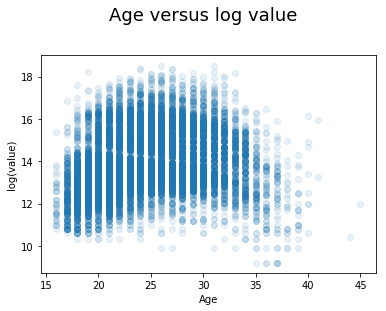

Pearson correlation = 0.18421933332162066


In [9]:
plt.scatter(x=df['age'],y=df['value_clean_log'],alpha=0.1)
plt.suptitle("Age versus log value",fontsize=18,y=1.05)
plt.xlabel("Age")
plt.ylabel("log(value)")
plt.show()


print(f"Pearson correlation = {pearsonr(df['value_clean_log'],df['age'])[0]}")

There seems to be a slight positive correlation between age and value (0.18) which suggests experience increases valuations, however, this is only up to a point. When the player age is aproximately >35 then the values tend to decline. This makes sense as older players have fewer years left in their career so have less long term value for the club.

**Player position**

The favoured position of each player (e.g. ST, RM, CF, GK etc.).

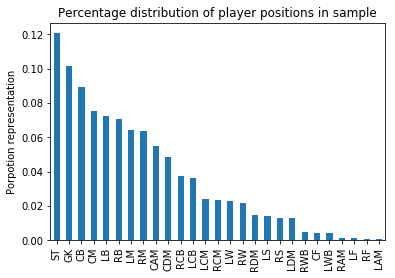

Number of unique positions = 27


In [10]:
df['Position'].value_counts(normalize=True).plot(kind='bar')
plt.title("Percentage distribution of player positions in sample")
plt.ylabel("Porpotion representation")
plt.show()

print(f"Number of unique positions = {df['Position'].nunique()}")

Position is the only categorical feature in the data.

Interestingly, striker is the most prevalent position in the dataset followed by goalkeepers.

There are 27 unique positions in the dataset. This is quite a lot for a categorical variable and it may be sensible to bucket these positions into more general categories (e.g. attacker, midfielder, defender etc..). I will create a new feature for these buckets.

In [11]:
def bucket_positions(pos):
    """Converts the specific position to a more general category"""
    
    POSITIONS_DICT = {
        'attack': ['CF', 'RF', 'LF', 'ST', 'LS', 'RS'],
        'midfield': ['CM', 'CAM', 'RM', 'CDM', 'LM', 'RCM', 'LCM', 'RDM', 'LDM', 'RAM', 'LAM', 'LW', 'RW'],
        'defence': ['LCB', 'CB', 'RB', 'RCB', 'LWB', 'LB', 'RWB'],
        'goal_keeper': ['GK']}

    for category, pos_list in POSITIONS_DICT.items():
        if pos in pos_list:
            return category
    
    return np.nan

In [12]:
df['Position_bucket'] = df['Position'].apply(bucket_positions)

del df['Position']

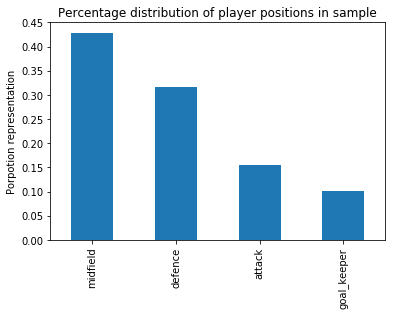

In [13]:
df['Position_bucket'].value_counts(normalize=True).plot(kind='bar')
plt.title("Percentage distribution of player positions in sample")
plt.ylabel("Porpotion representation")
plt.show()


This new feature is reduced to just four different categories.

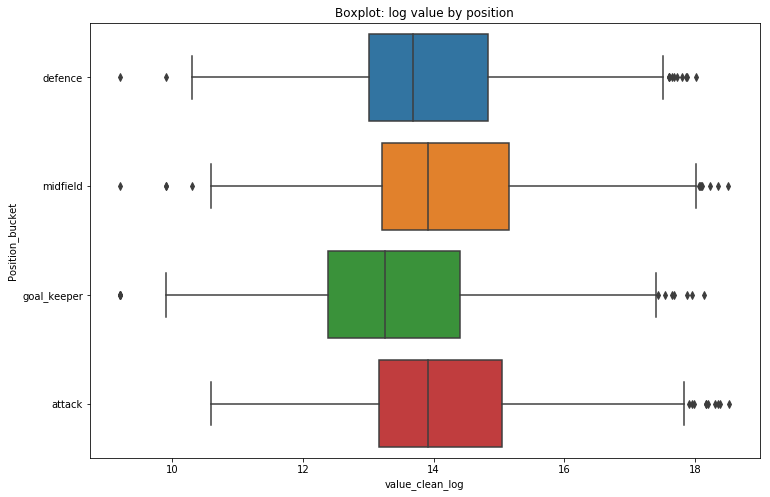

In [14]:
plt.figure(figsize=(12,8))
sns.boxplot(x='value_clean_log',y='Position_bucket',data=df)
plt.title("Boxplot: log value by position")
plt.show()

Looking at the distribution of valuations we see the distributions of log value are similar for each position category. Goal keepers tnd to have lower values on average and attackers tend to have higher 'value' which would be expected. Attackers have more outliers at the higher end of their distribution. Note also that this is a log scale, so although the distributions are similar, in real terms, attackers are valued at significant premium.

**Player attribute features**

There are 34 different columns which describe the player's playing attributes.


In [15]:
ATTRIBUTES

['Crossing',
 'Finishing',
 'Heading Accuracy',
 'Short Passing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FK Accuracy',
 'Long Passing',
 'Ball Control',
 'Acceleration',
 'Sprint Speed',
 'Agility',
 'Reactions',
 'Balance',
 'Shot Power',
 'Jumping',
 'Stamina',
 'Strength',
 'Long Shots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking',
 'Standing Tackle',
 'Sliding Tackle',
 'GK Diving',
 'GK Handling',
 'GK Kicking',
 'GK Positioning',
 'GK Reflexes']

I would assume that a lot of these features will be highly correlated with each other (e.g. Acceleration and sprint speed or goal keeping attributes will be negatively correlated with attacking attributes such as shooting, dribbling etc.), there could be scope to reduce the number of these features if necessary to improve the model and reduce complexity.

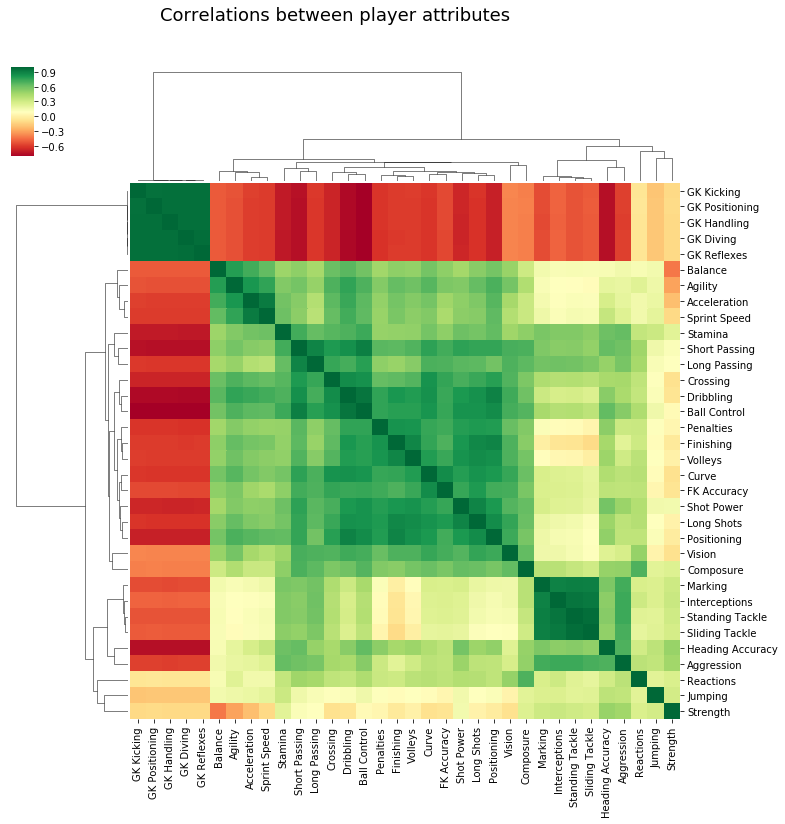

In [16]:
sns.clustermap(df[ATTRIBUTES].corr(),cmap='RdYlGn',figsize=(12,12))
plt.suptitle("Correlations between player attributes",fontsize=18,y=0.95)
plt.show()

There are a number of highly correlated features. Most notably, the goal keeping attributes (GK kicking, GK positioning, GK handling, GK diving and GK reflexes) are very correlated with each other and negatively correlated with the outfield attributes. Outfield attributes are generally all correlated with each other. Defending attributes (Marking, interceptions, standing tackle, sliding tackle etc) are very correlated with each other, however, the attacking attributes are not as strongly correlated. This shows that generally, goal keepers and defenders have a set of 'standard' skills whereas the attacking players have more specific skills sets (e.g. particularly good at volleying or crossing but not necessarily both.

**Player potential**

This is the overall rating that SOFIFA predicts to be the future potential for the player.

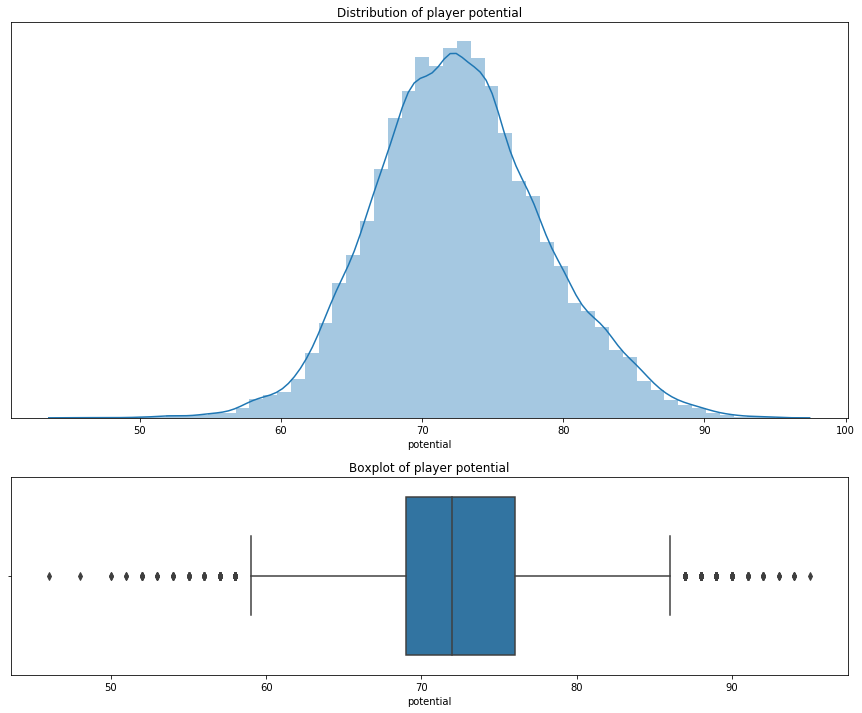

count    13719.000000
mean        72.657482
std          6.027961
min         46.000000
25%         69.000000
50%         72.000000
75%         76.000000
max         95.000000
Name: potential, dtype: float64

In [17]:
plot_distribution_and_stats(df['potential'],'player potential')

Player potential is pretty much normally distributed with a mean of 72.

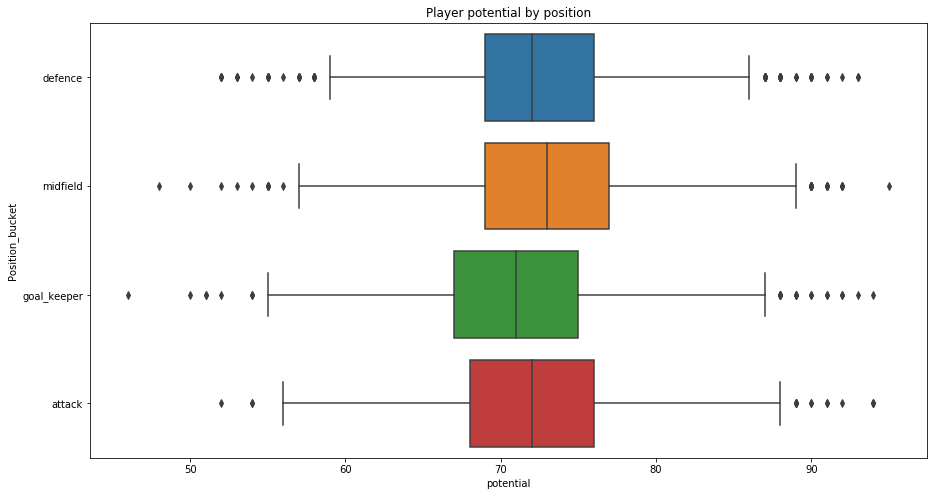

In [18]:
plt.figure(figsize=(15,8))
sns.boxplot(x='potential',y='Position_bucket',data=df)
plt.title("Player potential by position")
plt.show()

The player potential does not seem to be materially different for the different positions.

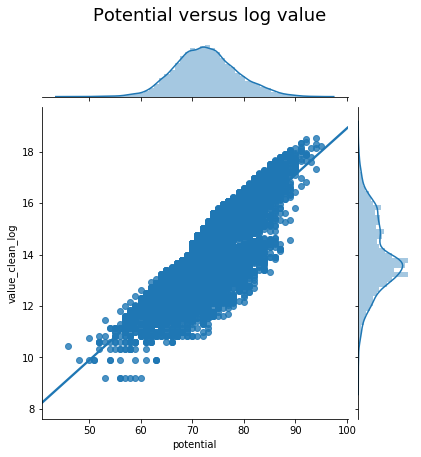

In [19]:
sns.jointplot(x='potential',y='value_clean_log',data=df,kind='reg')
plt.suptitle("Potential versus log value",fontsize=18,y=1.05)
plt.show()

There is a strong positive correlation between potential and the target variable, log(value).

Player potential and overall rating a probably very correlated, to check this we can plot potential versus overall rating.

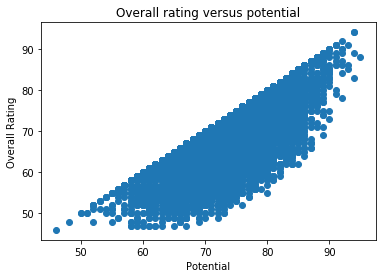

Pearson correlation = 0.6660520899052275


In [20]:
plt.scatter(x=df['potential'],y=df['overall_rating'])
plt.xlabel("Potential")
plt.ylabel("Overall Rating")
plt.title("Overall rating versus potential")
plt.show()

print(f"Pearson correlation = {pearsonr(df['potential'],df['overall_rating'])[0]}")

We can see that the overall rating is always lower than the player potential, which makes sense. However, the correlation is only 0.66, therefore it is probably useful to keep both features for modelling.

Another feature that could be of interest is the difference between the current player rating and the player potential. I will create this feature and call it 'potential_growth'. Players with higher growth potential may be of higher value for their current overall rating.

In [21]:
#create new feature
df['potential_growth'] = df['potential']-df['overall_rating']

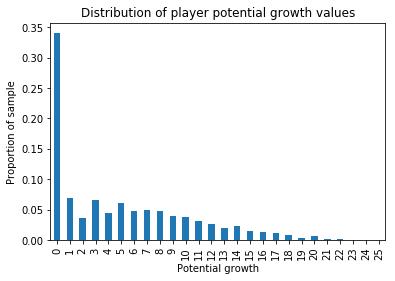

In [22]:
df['potential_growth'].value_counts(normalize=True).sort_index().plot(kind='bar')
plt.title("Distribution of player potential growth values")
plt.ylabel("Proportion of sample")
plt.xlabel("Potential growth")
plt.show()

We can see that most players are already at their maximum potential (difference between potential and current overall rating = 0). The potential growth ranges up to 25 additional points.

To see how this new feature correlates to the target variable we can plot potential growth versus log(value) and also calculate the peason correlation. Growth potential is also likely to be correlated to the overall rating so we will also plot this relationship

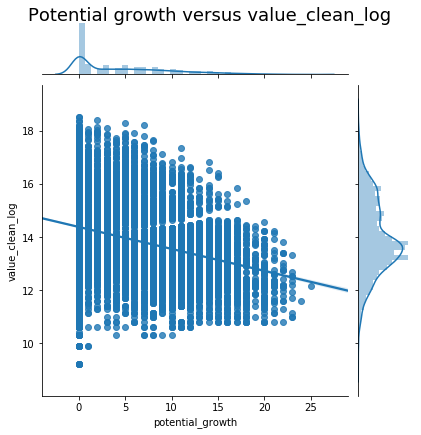

Pearson correlation = -0.31245629202124825


In [23]:
sns.jointplot(x='potential_growth',y='value_clean_log',data=df,kind='reg')
plt.suptitle("Potential growth versus value_clean_log",fontsize=18,y=1)
plt.show()

print(f"Pearson correlation = {pearsonr(df['value_clean_log'],df['potential_growth'])[0]}")


INSERT THRID DIMENSION TO CONVEY OVERALL RATING E.G. MAKE PLOT COLOUR CODED FOR OVERALL RATING

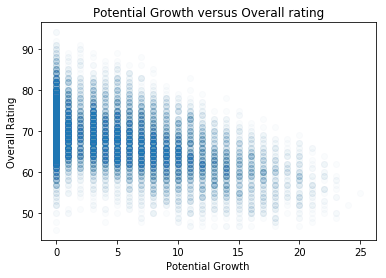

Pearson correlation = -0.5160447194481983


In [24]:
plt.scatter(x=df['potential_growth'],y=df['overall_rating'],alpha=0.02)
plt.title("Potential Growth versus Overall rating")
plt.xlabel("Potential Growth")
plt.ylabel("Overall Rating")
plt.show()
print(f"Pearson correlation = {pearsonr(x=df['potential_growth'],y=df['overall_rating'])[0]}")

Interestingly, the potential growth is negatively correlated with the log value which tells us that the higher the potential growth, the lower the current player value is. This is intuitive as players with high growth potential almost by definition must have a lower overall rating and thus lower current value. However, the plot of potential growth aginst log(value) shows a narrowing of the 'funnel' and lower variance in the values of players with higher growth potential suggesting that players with high growth potential are valued at a premium.

Looking at the overall rating versus potential growth chart the correlation is only -0.51 suggesting that the new feature contains new information and may be useful to add to the model.

In [25]:
#del df['potential_growth']

**Player overall rating**

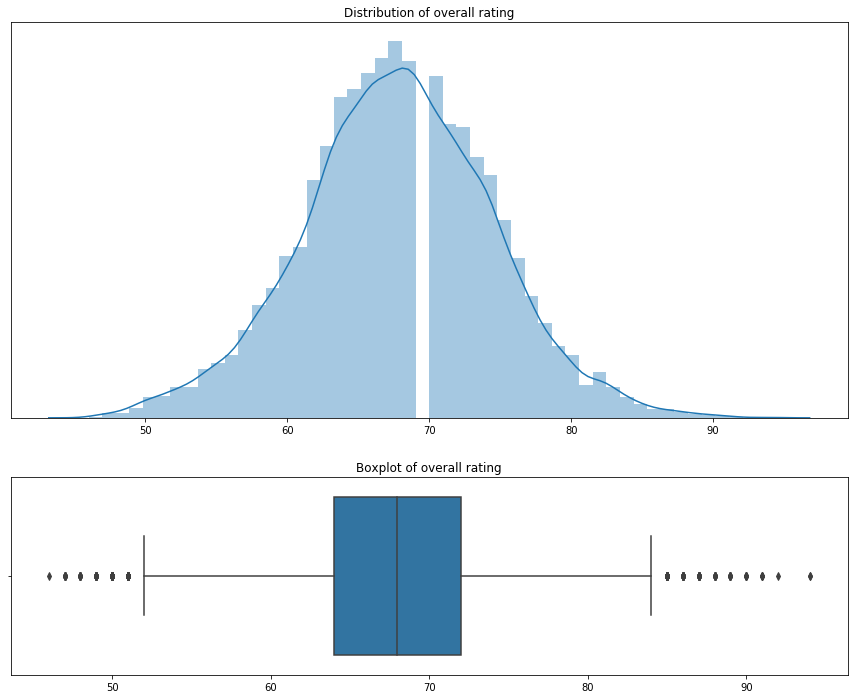

,overall_rating
count,13719.000000
mean,67.789416
std,6.723772
min,46.000000
25%,64.000000
50%,68.000000
75%,72.000000
max,94.000000


In [26]:
plot_distribution_and_stats(df[['overall_rating']],'overall rating')

Overall rating is normally distributed with a average of 68, min of 46 and max of 94. The distribution has long tails on both sides with low and high outliers.

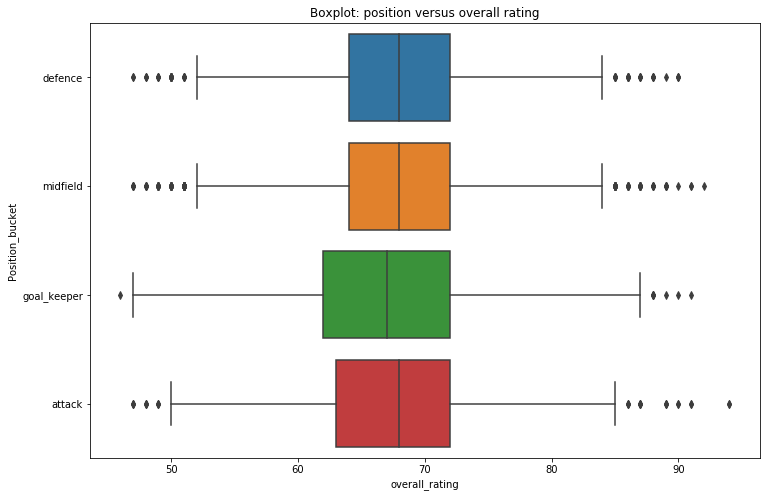

In [27]:
plt.figure(figsize=(12,8))
sns.boxplot(x='overall_rating',y='Position_bucket',data=df)
plt.title("Boxplot: position versus overall rating")
plt.show()

The overall ratings for each player position are very similar. Interestingly, this is in contrast to the boxplot of player position versus log value, where attackers had a higher value. This suggests that attackers come at a premium compared to their overall rating.

R2 = 0.8971417115266501


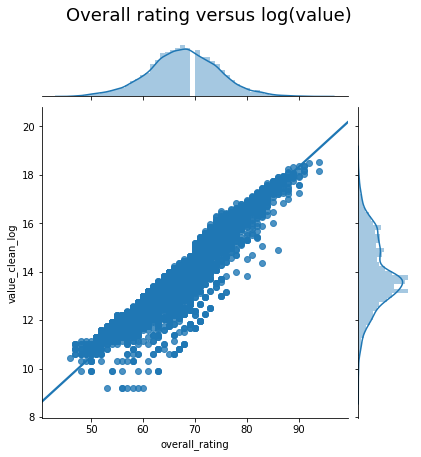

In [28]:
sns.jointplot(df['overall_rating'],
              df['value_clean_log'],
              kind="reg")
plt.suptitle("Overall rating versus log(value)",fontsize=18,y=1.05)

print(f"R2 = {pearsonr(df['overall_rating'],df['value_clean_log'])[0]**2}")


Overall rating is highly correlated with log value with an R2 of 0.89 and is likely to be the most predictive feature

### EDA summary

1. The target variable, player value, was log transformed to normalize the distribution.
2. Player position, a categorical attribute with high cardinality was converted into more general positions (e.g. attacker, defender, midfielder, goal keeper etc.). The distribution of player values for each position was similar, however, attacking players seem to be valued at a premium for their overall rating.
3. A new feature, potential growth, was created by calculating the difference between 'potential' and 'overall rating'. This new feature showed that players with a high gorwth potential tend to be valued at a premium to other players of the same overall rating..... PLOT TO BE COMPLETED.
4. The playing attributes (crossing, passing etc.) tend to be correlated strongly with each other but do not strongly correlate to player value. It may be necessary to combine some of these attribtues together to reduce the model complexity. Of the playing attributes, reactions and composure seem to be the most correlated to value.
5. Player value increases with age, however, after about age 35 the value of players starts to drop.

A summary of the numerical feature correlations to the target variable (log(value)) are summarised below:

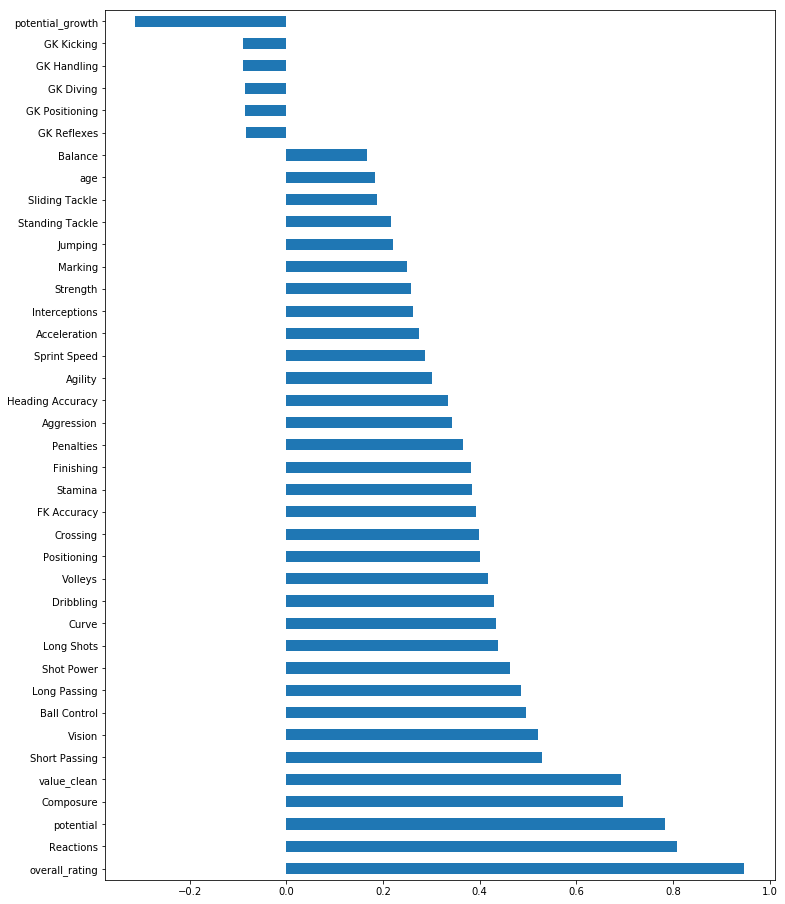

In [29]:
#correlation between each feature and the target variable (value_clean_log)
display(HTML("<b>Feature correlations to the target variable, log(value)</b>"))
df.corr()['value_clean_log'].sort_values(ascending=False).iloc[1:].plot(kind='barh',figsize=(12,16))
plt.show()

------------------------

# Modelling

## Data Preparation

For modelling I will create a new function which loads the raw data and applies the data cleaning/feature creation steps carried out in the EDA. We will then create the test train split and a sklearn pipeline for feature scaling and processing.

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

#load in raw data again
def make_data_set():
    """Loads raw data and applies initial feature creation/processing steps"""
    
    #load raw data
    raw_df = pd.read_csv("data/1. processed/data_clean.csv")    
    df = raw_df.loc[raw_df['value_clean']!=0].copy() #delete rows with 0 in value_clean column

    #select sensible features
    df = df[ATTRIBUTES + ['age','overall_rating','potential','Position','value_clean']].copy()
    
   
    #drop missing position datapoints
    df = df.loc[df['Position'].notnull()].copy()
    
    #create player position buckets
    df['Position_bucket'] = df['Position'].apply(bucket_positions) 
    del df['Position']
    
    #create new feature for potential growth
    df['potential_growth'] = df['potential']-df['overall_rating']
    
    #log transform value_clean attribute
    df['target'] = np.log(df['value_clean'])
    del df['value_clean']
    
    #make sure no missing data
    assert df.isnull().sum().sum() == 0
    
    #shuffle the dataframe just incase their was any bias in the order that the data was collected
    df_shuffled = shuffle(df, random_state=0)

    #create train and test split
    return train_test_split(df_shuffled.iloc[:,:-1],
                            df_shuffled.iloc[:,-1],
                            test_size=0.33,
                            random_state=0)

In [31]:
#create training and final test sets
X_train, X_test, y_train, y_test = make_data_set()

## Baseline model

To evaluate the effectiveness of the machine learning model we need to decide which accuracy metric to optimise for and also evaluate the model performance against a simple baseline model.

From the EDA section we discovered that overall rating had the highest correlation with the value of the player (0.94). Therefore the simplest model with good performance is likely to be a linear regression of overall rating versus log(value).

We will optimise for RSME (root mean squared error) because we want to be able to predict the value of a player, in particular the players which are significantly under of over valued. Therefore we want to choose a metric which penalises very bad predictions more than predictions which are only marginally off the actual value. MSE is given by the following equation:

$$RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{e^2}}$$

Where $e$ is the error (difference between predicted and actual).  

As this is a squared term, large errors will be amplified and increase the RSME and lead to a worse performance of the model.

In [32]:
#dict to store modelling results
model_results = {}

#claculate adjusted r-squared
def calc_adj_r2(training_data,r2):
    """calculates the adjusted r2 for the model"""
    num_data_points = len(training_data)
    num_features = len(training_data.columns)
    return  1-((1-r2)*(num_data_points-1)/(num_data_points-num_features-1))

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x = X_train['overall_rating'].values.reshape(-1,1)
y = y_train.values.reshape(-1,1)

baseline_model = LinearRegression()
baseline_model.fit(x,y)

baseline_pred = baseline_model.predict(X_train['overall_rating'].values.reshape(-1,1))
baseline_RMSE = np.sqrt(mean_squared_error(y_train, baseline_pred))
baseline_r2 = r2_score(y_train,baseline_pred)
baseline_adj_r2 = calc_adj_r2(X_train[['overall_rating']],baseline_r2)

#add result to model_results dictionary
model_results['baseline model (linear regression)'] = {'rmse':baseline_RMSE,
                                                      'adj. r2':baseline_adj_r2}
pd.DataFrame.from_dict(model_results,orient='index')

,rmse,adj. r2
baseline model (linear regression),0.438973,0.900383


The baseline linear regression gives a RMSE of 0.43 and an R-squared score of 0.90. This is already reasonably good model, however, there is still room for improvement, and it also does not give any insight into other variables which could affect the value of each player.

## Multiple Linear Regression


In [58]:
#create dummy variables for multiple linear regression 
X_train_mlr = pd.get_dummies(X_train,drop_first=True)
X_test_mlr = pd.get_dummies(X_test,drop_first=True)

X_train_mlr.head()

,Crossing,Finishing,Heading Accuracy,Short Passing,Volleys,Dribbling,Curve,FK Accuracy,Long Passing,Ball Control,Acceleration,Sprint Speed,Agility,Reactions,Balance,Shot Power,Jumping,Stamina,Strength,Long Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,Standing Tackle,Sliding Tackle,GK Diving,GK Handling,GK Kicking,GK Positioning,GK Reflexes,age,overall_rating,potential,potential_growth,Position_bucket_defence,Position_bucket_goal_keeper,Position_bucket_midfield
104,54,55,34,68,48,68,58,50,60,71,74,66,77,60,83,59,51,64,43,61,53,44,59,62,48,62,37,45,41,12,11,8,12,6,18,66,82,16,0,0,1
3367,83,72,42,73,73,76,83,84,72,74,76,74,84,73,73,83,62,71,61,81,53,35,71,83,85,77,42,21,20,10,7,14,7,10,31,76,76,0,0,0,1
4816,60,62,54,62,71,72,65,45,59,68,75,77,69,62,58,71,60,65,70,63,51,33,68,62,56,63,32,31,30,11,8,13,8,8,21,67,75,8,0,0,1
11395,39,62,44,47,50,66,50,51,37,68,73,78,73,61,71,61,33,48,59,63,46,38,67,46,62,44,41,20,22,8,9,13,6,13,24,59,65,6,0,0,1
11263,51,54,47,63,45,63,50,51,53,64,67,63,69,54,71,59,55,60,62,49,40,26,53,58,48,56,28,39,45,15,7,11,11,12,24,60,64,4,0,0,1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.179e+05
Date:                Sun, 13 Oct 2019   Prob (F-statistic):               0.00
Time:                        19:06:01   Log-Likelihood:                -320.60
No. Observations:                9191   AIC:                             721.2
Df Residuals:                    9151   BIC:                             1006.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Crossing                       -0.0014      0.000     -3.675      0.000      -0.002      -0.001
Finishing                       0.0010      0.000      2.164      0.031    9.22e-05       0.002
Heading Accuracy                0.0024      0.000      6.129      0.000       0.002       0.003
Short Passing                   0.0010      0.001      1.484      0.138      -0.000       0.002
Volleys                         0.0006      0.000      1.467      0.143      -0.000       0.001
Dribbling                       0.0001      0.001      0.215      0.830      -0.001       0.001
Curve                           0.0002      0.000      0.584      0.559      -0.001       0.001
FK Accuracy                     0.0009      0.000      2.787      0.005       0.000       0.002
Long Passing                   -0.0003      0.000     -0.604      0.546      -0.001       0.001
Ball Control                   -0.0024      0.001     -3.200      0.001      -0.004      -0.001
Acceleration                    0.0013      0.001      2.375      0.018       0.000       0.002
Sprint Speed                    0.0004      0.001      0.702      0.483      -0.001       0.001
Agility                        -0.0002      0.000     -0.569      0.569      -0.001       0.001
Reactions                    9.072e-05      0.001      0.142      0.887      -0.001       0.001
Balance                         0.0015      0.000      4.352      0.000       0.001       0.002
Shot Power                  -9.341e-05      0.000     -0.231      0.817      -0.001       0.001
Jumping                     -7.115e-05      0.000     -0.256      0.798      -0.001       0.000
Stamina                         0.0015      0.000      4.428      0.000       0.001       0.002
Strength                        0.0015      0.000      4.359      0.000       0.001       0.002
Long Shots                     -0.0007      0.000     -1.590      0.112      -0.002       0.000
Aggression                     -0.0005      0.000     -1.595      0.111      -0.001       0.000
Interceptions                  -0.0003      0.000     -0.696      0.486      -0.001       0.001
Positioning                     0.0013      0.000      2.987      0.003       0.000       0.002
Vision                          0.0002      0.000      0.411      0.681      -0.001       0.001
Penalties                       0.0005      0.000      1.440      0.150      -0.000       0.001
Composure                      -0.0017      0.000     -3.804      0.000      -0.003      -0.001
Marking                        -0.0016      0.000     -4.389      0.000      -0.002      -0.001
Standing Tackle                 0.0007      0.001      1.072      0.284      -0.001       0.002
Sliding Tackle                 -0.0009      0.001     -1.469      0.142      -0.002       0.000
GK Diving  

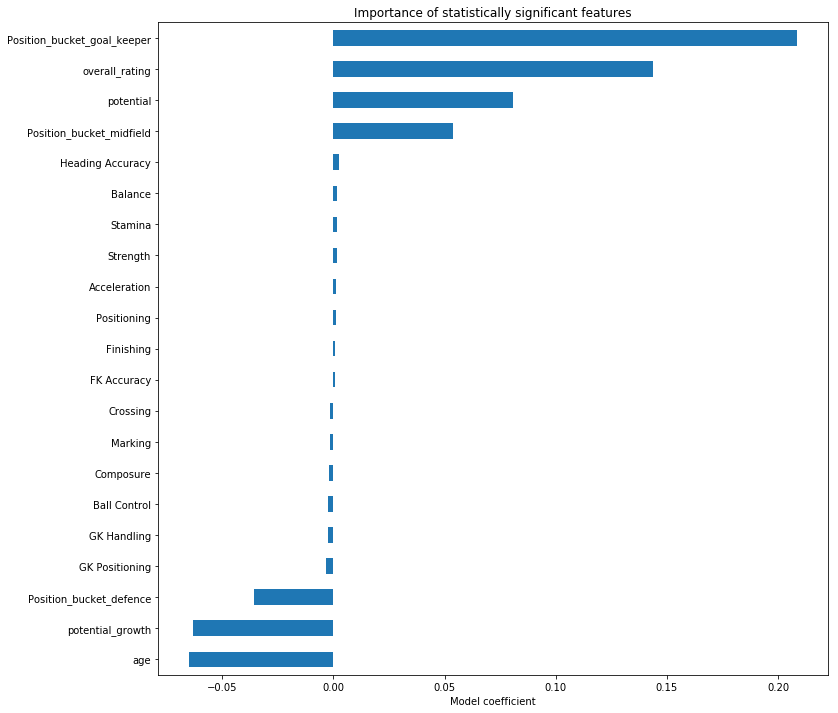

,rmse,adj. r2
Multiple Linear Regression,0.250560,0.967403
baseline model (linear regression),0.438973,0.900383


In [36]:
import statsmodels.api as sm

mlr_model = sm.OLS(y_train,X_train_mlr).fit()
mlr_pred = mlr_model.predict(X_train_mlr)

mlr_RMSE = np.sqrt(mean_squared_error(y_train, mlr_pred))
mlr_r2 = r2_score(y_train,mlr_pred)
mlr_adj_r2 = calc_adj_r2(X_train_mlr,mlr_r2)


display(HTML("<h3>Regression Results</h3>"))
display(mlr_model.summary())

display(HTML("<h3>Statistically Significant Feautre Importances</h3>"))
plt.figure(figsize=(12,12))
mlr_model.params[mlr_model.pvalues<0.05].sort_values().plot(kind='barh')
plt.title("Importance of statistically significant features")
plt.xlabel("Model coefficient")
plt.show()

display(HTML(f"""<h4>Statistically insignificant variables</h4><p>{mlr_model.params[mlr_model.pvalues>0.05].index.tolist()}</p>"""))
        
        
#add result to model_results dictionary
model_results['Multiple Linear Regression'] = {'rmse':mlr_RMSE,
                                              'adj. r2':mlr_adj_r2}

display(HTML("<h3>Model comparison</h3>"))
display(pd.DataFrame.from_dict(model_results,orient='index'))

The output above shows the multiple linear regression results when using all the available features.

The multiple linear regression is an improvement on the baseline model, with a RMSE of 0.25. The adjusted r2 is also higher than the simple linear regression, indicating that although the model is more complex, the added complexity improves the predictive performance of the model.

Overall rating, potential, potential growth and age have high absolute feature importane as expected from the EDA analysis. The player position also appears to have a big impact on the model's predictions. Most player attributes are statistically insignificant for predicting player value and for those that are statistically significant they have very low feature importances. This suggests that these features for a multiple linear regression model and complexity without improving the performance and should be considered as candidates for dropping from the model.

### Multiple Linear Regression - Backward elimination

To improve the multiple linear regression model we can try a backward elimination technique which sequentially removes variables which are statistically insignificant from the model. This helps to reduce the model complexity whilst maintaining the significant variables.

In [37]:
#Backward Elimination
#Iteratively fit model and remove statistically insignificant variables

cols = list(X_train_mlr.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X_train_mlr[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y_train,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break

mlr_be_selected_features = cols
print(mlr_be_selected_features)

['Heading Accuracy', 'Volleys', 'FK Accuracy', 'Ball Control', 'Reactions', 'Balance', 'Strength', 'Positioning', 'Marking', 'Sliding Tackle', 'GK Handling', 'GK Positioning', 'age', 'overall_rating', 'potential', 'potential_growth', 'Position_bucket_defence']


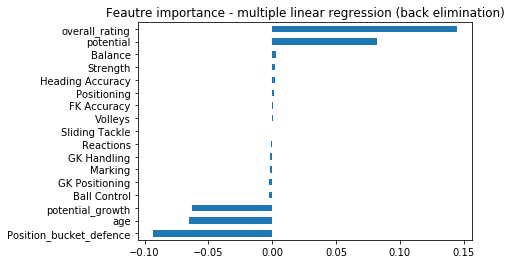

In [40]:
mlr_be_model = sm.OLS(
    y_train, X_train_mlr[mlr_be_selected_features]).fit()

mlr_be_pred = mlr_be_model.predict(
    X_train_mlr[mlr_be_selected_features])

mlr_be_RMSE = np.sqrt(
    mean_squared_error(y_train, mlr_be_pred))

mlr_be_r2 = r2_score(y_train, mlr_be_pred)
mlr_be_adj_r2 = calc_adj_r2(X_train_mlr[mlr_be_selected_features],mlr_be_r2)

mlr_be_model.params.sort_values().plot(kind='barh')
plt.title("Feautre importance - multiple linear regression (back elimination)")
plt.show()

In [41]:
model_results['Multiple Linear Regression - Backward Elimination'] = {'rmse':mlr_be_RMSE,
                                                                     'adj. r2':mlr_be_adj_r2}

pd.DataFrame.from_dict(model_results,orient='index').sort_values('rmse')

,rmse,adj. r2
Multiple Linear Regression,0.250560,0.967403
Multiple Linear Regression - Backward Elimination,0.252326,0.967028
baseline model (linear regression),0.438973,0.900383


The multiple linear regression using a reduced set of features gives a very similar rmse and adjusted r-squared to the regression model which included all features. As the performance is very similar, but the model complexity of the reduced model is lower, it should be considered as a better candidate.

## Machine Learning Methods

For data preprocessing, the numeric attributes will be scaled using a z-score transformation and the single categorical attribute (position_bucket) will be one-hot encoded.

For this excercise I will compare the performance of three ML models:
- Decision trees
- Random forests 
- XGBoost

To see which model performs the best, I will use cross fold validation with gridsearch CV for hyper parameter tuning and record the best performing model. 

I will use sklearn Pipelines to scale and process the data into the correct format for each of the ML algorithms. This is a more robust method for data preparation and ensures repeatability across different models.


**Set up pipelines**

- general preprocessing

In [42]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

assert len(numeric_features.append(categorical_features))==len(X_train.columns)


numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

nominal_categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())])

#apply transformations to numerical and categroical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', nominal_categorical_transformer, categorical_features)])

- pipelines for each regression model

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeRegressor(random_state=0))
])

pipe_dt_pca = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('dt', DecisionTreeRegressor(random_state=0))
])


pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(random_state=0))
])


pipe_rf_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('rf', RandomForestRegressor(random_state=0))
])


pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbrg', XGBRegressor())
])


pipe_xgb_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=6)),
    ('xgbrg', XGBRegressor())
])

- Metric

In [45]:
from sklearn.metrics import mean_squared_error
def root_mean_squared_error(y_true, y_pred):
    """Root mean squared error regression loss"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [46]:
from sklearn.metrics import make_scorer
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

- Grid search

In [47]:
CV_FOLDS = 5
N_JOBS = -1
VERBOSE = 1

In [48]:
dt_param_grid = {"dt__min_samples_split": [10, 20, 40],
      "dt__max_depth": [2, 6, 8],
      "dt__min_samples_leaf": [20, 40, 100],
      "dt__max_leaf_nodes": [5, 20, 100],
     }

gs_dt = GridSearchCV(estimator=pipe_dt,
                     param_grid=dt_param_grid,
                     scoring=rmse_scorer,
                     n_jobs=N_JOBS,
                     verbose=VERBOSE,
                     cv=CV_FOLDS)

gs_dt_pca = GridSearchCV(estimator=pipe_dt_pca,
                         param_grid=dt_param_grid,
                         scoring=rmse_scorer,
                         n_jobs=N_JOBS,
                         verbose=VERBOSE,
                         cv=CV_FOLDS)

In [49]:
rf_param_grid = {"rf__min_samples_split": [10, 20, 40],
                  "rf__max_depth": [2, 6, 8],
                  "rf__min_samples_leaf": [20, 40, 100],
                  "rf__max_leaf_nodes": [5, 20, 100],
                 }

gs_rf = GridSearchCV(estimator=pipe_rf,
                     param_grid= rf_param_grid,
                     scoring=rmse_scorer,
                     n_jobs = N_JOBS,
                     verbose = VERBOSE,
                     cv=CV_FOLDS) 

gs_rf_pca = GridSearchCV(estimator=pipe_rf_pca,
                     param_grid= rf_param_grid,
                     scoring=rmse_scorer,
                     n_jobs = N_JOBS,
                     verbose = VERBOSE,
                     cv=CV_FOLDS) 

In [50]:
xgb_param_grid = {
    "xgbrg__n_estimators": [10, 50, 100, 500, 1000],
    "xgbrg__learning_rate": [0.1, 0.5, 1]
}


gs_xgb = GridSearchCV(estimator=pipe_xgb,
                     param_grid= xgb_param_grid,
                     scoring=rmse_scorer,
                     n_jobs = N_JOBS,
                     verbose = VERBOSE,
                     cv=CV_FOLDS) 

gs_xgb_pca = GridSearchCV(estimator=pipe_xgb_pca,
                     param_grid= xgb_param_grid,
                     scoring=rmse_scorer,
                     n_jobs = N_JOBS,
                     verbose = VERBOSE,
                     cv=CV_FOLDS)  

In [51]:
from sklearn.externals import joblib

# List of pipelines for ease of iteration
grids = [gs_dt, gs_dt_pca, gs_rf, gs_rf_pca, gs_xgb, gs_xgb_pca]

# Dictionary of pipelines and classifier types for ease of reference
grid_dict = {0: 'Decision Tree', 1: 'Decision Tree w/PCA', 
             2: 'Random Forest', 3: 'Random Forest w/PCA', 
             4: 'XGBoost', 5: 'XGBoost w/PCA'}


# Fit the grid search objects
print('Performing model optimizations...')
best_rmse = 1.0
best_model = 0
best_gs = ''

for idx, gs in enumerate(grids):
    print(f"\nEstimator: {grid_dict[idx]}")
    # Fit grid search
    gs.fit(X_train, y_train)
    # Best params
    print(f"Best params: {gs.best_params_}")
    # Best training data accuracy
    print(f"Best training accuracy: {-gs.best_score_}")
    # Predict on test data with best params
    y_pred = gs.predict(X_test)
    # Test data accuracy of model with best params
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE of best {grid_dict[idx]} model on all training data: {rmse}")
    #Add result to dictionary of model results
    r2 = r2_score(y_test,y_pred)
    model_results[grid_dict[idx]]= {'rmse': rmse,
                                   'adj. r2': calc_adj_r2(X_test,r2)}

    # Track best (highest test accuracy) model
    if rmse < best_rmse:
        best_rmse = rmse
        best_gs = gs
        best_model = idx
        print(f"\nClassifier with best test set accuracy: {grid_dict[best_model]}")

# Save best grid search pipeline to file
dump_file = 'best_gs_model.pkl'
joblib.dump(best_gs, dump_file, compress=1)
print(f"\nSaved {grid_dict[best_model]} grid search pipeline to file: {dump_file}")

Performing model optimizations...

Estimator: Decision Tree
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   21.3s finished


Best params: {'dt__max_depth': 8, 'dt__max_leaf_nodes': 100, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 10}
Best training accuracy: 0.210086813549119
RMSE of best Decision Tree model on all training data: 0.197168277359902

Classifier with best test set accuracy: Decision Tree

Estimator: Decision Tree w/PCA
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   17.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best params: {'dt__max_depth': 8, 'dt__max_leaf_nodes': 100, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 10}
Best training accuracy: 0.5332740730930358
RMSE of best Decision Tree w/PCA model on all training data: 0.5334701924549451

Estimator: Random Forest
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.1min finished


Best params: {'rf__max_depth': 8, 'rf__max_leaf_nodes': 100, 'rf__min_samples_leaf': 20, 'rf__min_samples_split': 10}
Best training accuracy: 0.18066137626414985
RMSE of best Random Forest model on all training data: 0.16790229494325498

Classifier with best test set accuracy: Random Forest

Estimator: Random Forest w/PCA
Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:   35.3s finished


Best params: {'rf__max_depth': 8, 'rf__max_leaf_nodes': 100, 'rf__min_samples_leaf': 20, 'rf__min_samples_split': 10}
Best training accuracy: 0.4328837008399145
RMSE of best Random Forest w/PCA model on all training data: 0.4253850735508838

Estimator: XGBoost
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.7min finished


[19:12:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best params: {'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 1000}
Best training accuracy: 0.09708663717478175
RMSE of best XGBoost model on all training data: 0.07935367591959631

Classifier with best test set accuracy: XGBoost

Estimator: XGBoost w/PCA
Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.3min finished


[19:13:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best params: {'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 1000}
Best training accuracy: 0.29026112419537625
RMSE of best XGBoost w/PCA model on all training data: 0.27972386450975373

Saved XGBoost grid search pipeline to file: best_gs_model.pkl


In [52]:
pd.DataFrame.from_dict(model_results,orient='index')

,rmse,adj. r2
Decision Tree,0.197168,0.979451
Decision Tree w/PCA,0.533470,0.849571
Multiple Linear Regression,0.250560,0.967403
Multiple Linear Regression - Backward Elimination,0.252326,0.967028
Random Forest,0.167902,0.985099
Random Forest w/PCA,0.425385,0.904352
XGBoost,0.079354,0.996672
XGBoost w/PCA,0.279724,0.958641
baseline model (linear regression),0.438973,0.900383


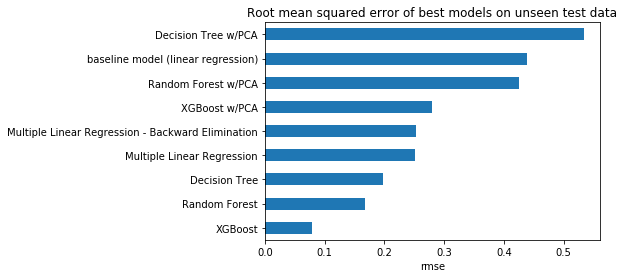

In [60]:
pd.DataFrame.from_dict(model_results,orient='index')['rmse'].sort_values().plot(kind='barh')
plt.title("Root mean squared error of best models on unseen test data")
plt.xlabel("rmse")
plt.show()

XGboost had the best performance of all the models with a root mean squared error of 0.079 on the completely unseen test data.

This is a big improvement on the initial baseline regression model and multiple linear regression models. I will use the XGBoost model as the candidate for further investigation.

# Model Interpretation

### Decision Tree

In [74]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dt', DecisionTreeRegressor(criterion='mse',random_state=0))
])


pg = {"dt__min_samples_split": [10, 20, 40],
      "dt__max_depth": [2, 6, 8],
      "dt__min_samples_leaf": [20, 40, 100],
      "dt__max_leaf_nodes": [5, 20, 100],
     }

grid = GridSearchCV(dt_pipeline, param_grid=pg, cv=5,verbose=10,n_jobs=-1,refit=True)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), Index(['Crossing', 'Finishing', '..._split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'dt__min_samples_split': [10, 20, 40], 'dt__max_depth': [2, 6, 8], 'dt__min_samples_leaf': [20, 40, 100], 'dt__max_leaf_nodes': [5, 20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

- box plot of accuracies

In [75]:
print(grid.best_params_)

print(np.sqrt(grid.best_score_))

{'dt__max_depth': 8, 'dt__max_leaf_nodes': 100, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 10}
0.9884635905860464


In [72]:
dt_pred = grid.predict(X_test)

dt_RMSE = np.sqrt(mean_squared_error(y_test, dt_pred))

print(dt_RMSE)

0.19716827735990206


C:\Users\westj\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [95]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestRegressor(criterion='mse',random_state=0))
])


pg = {"rf__min_samples_split": [10, 20, 40],
      "rf__max_depth": [2, 6, 8],
      "rf__min_samples_leaf": [20, 40, 100],
      "rf__max_leaf_nodes": [5, 20, 100],
     }

grid = GridSearchCV(rf_pipeline, param_grid=pg, cv=5,verbose=10,n_jobs=-1,refit=True)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), Index(['Crossing', 'Finishing', '...tors='warn', n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'rf__min_samples_split': [10, 20, 40], 'rf__max_depth': [2, 6, 8], 'rf__min_samples_leaf': [20, 40, 100], 'rf__max_leaf_nodes': [5, 20, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [96]:
rf_pred = grid.predict(X_test)

rf_RMSE = np.sqrt(mean_squared_error(y_test, rf_pred))

print(rf_RMSE)

0.1680029165501023


C:\Users\westj\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


### XGBoost

In [ ]:
param_grid = {
    "xgbrg__n_estimators": [10, 50, 100, 500],
    "xgbrg__learning_rate": [0.1, 0.5, 1],
}

fit_params = {"xgbrg__eval_set": [(X_test, y_test)], 
              "xgbrg__early_stopping_rounds": 10, 
              "xgbrg__verbose": 10} 

searchCV = GridSearchCV(my_pipeline, cv=5, param_grid=param_grid, fit_params=fit_params)
searchCV.fit(X_train,y_train)  

In [113]:
#Building XGboost
from xgboost import XGBRegressor


xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbrg', XGBRegressor())])


param_grid = {
    "xgbrg__n_estimators": [10, 50, 100, 500, 1000],
    "xgbrg__learning_rate": [0.1, 0.5, 1]
}

fit_params = {"xgbrg__eval_metric":"logloss"}

# fit_params = {"xgbrg__eval_set": [(X_test, y_test)], 
#               "xgbrg__early_stopping_rounds": 10, 
#               "xgbrg__verbose": 10} 

grid = GridSearchCV(xgb_pipeline, cv=5, 
                    param_grid=param_grid,
                    fit_params=fit_params,
                    n_jobs=-1,verbose=10)
grid.fit(X_train,y_train)  
     

C:\Users\westj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   55.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.9min finished
C:\Users\westj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\westj\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64 were all converted to float64 by

[08:42:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), Index(['Crossing', 'Finishing', '...lpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1))]),
       fit_params={'xgbrg__eval_metric': 'logloss'}, iid='warn', n_jobs=-1,
       param_grid={'xgbrg__n_estimators': [10, 50, 100, 500, 1000], 'xgbrg__learning_rate': [0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [114]:
xgb_predict = grid.predict(X_test)

xgb_RMSE = np.sqrt(mean_squared_error(y_test, xgb_predict))

print(grid.best_params_)

print(xgb_RMSE)

C:\Users\westj\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


{'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 1000}
0.08415465935662358


The XGboost algorithm has performed much better than the other models! With a RMSE of only 0.0864 on the test set. It will be interesting to gain some more insight from this model.

We can use the SHAP package for this purpose.

In [122]:
import xgboost
#xgboost.plot_importance(grid.fit(X_train,y_train))
grid.best_params_

{'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 1000}

In [115]:
import shap
shap.initjs()

In [129]:
X_train_shap = X_train.copy()
X_train_shap = pd.get_dummies(X_train_shap,drop_first=True)

scaler = StandardScaler()
X_train_shap[numeric_features] = scaler.fit_transform(X_train_shap[numeric_features])

xgb_best_model = XGBRegressor(learning_rate= 0.1, 
                              n_estimators= 1000).fit(X_train_shap,y_train)


C:\Users\westj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\westj\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\westj\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[09:24:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [130]:
#pipelines objects are not supported by shap, therefore will re

explainer = shap.TreeExplainer(xgb_best_model)

In [131]:
shap_values = explainer.shap_values(X_train_shap)

In [143]:
shap.force_plot(explainer.expected_value, 
                shap_values[0,:],
               X_train_shap.columns)

#print(np.exp(y_train.iloc[0]))

1299999.9999999998


In [157]:
def convert_to_readable_number(x):
    if x/1000000>1:
        return f"${round(x/1000000,2)}M"
    else:
        return f"${round(x/1000)}K"

In [155]:
convert_to_readable_number(np.exp(y_train.iloc[0]))

'$1.3M'

In [200]:
f"{int(np.exp(y_train.iloc[0])):,}"

'1,299,999'

In [156]:
convert_to_readable_number(np.exp(xgb_predict[0]))

'$1.88M'

In [151]:
X_train.iloc[0]


Crossing                  54
Finishing                 55
Heading Accuracy          34
Short Passing             68
Volleys                   48
Dribbling                 68
Curve                     58
FK Accuracy               50
Long Passing              60
Ball Control              71
Acceleration              74
Sprint Speed              66
Agility                   77
Reactions                 60
Balance                   83
Shot Power                59
Jumping                   51
Stamina                   64
Strength                  43
Long Shots                61
Aggression                53
Interceptions             44
Positioning               59
Vision                    62
Penalties                 48
Composure                 62
Marking                   37
Standing Tackle           45
Sliding Tackle            41
GK Diving                 12
GK Handling               11
GK Kicking                 8
GK Positioning            12
GK Reflexes                6
age           

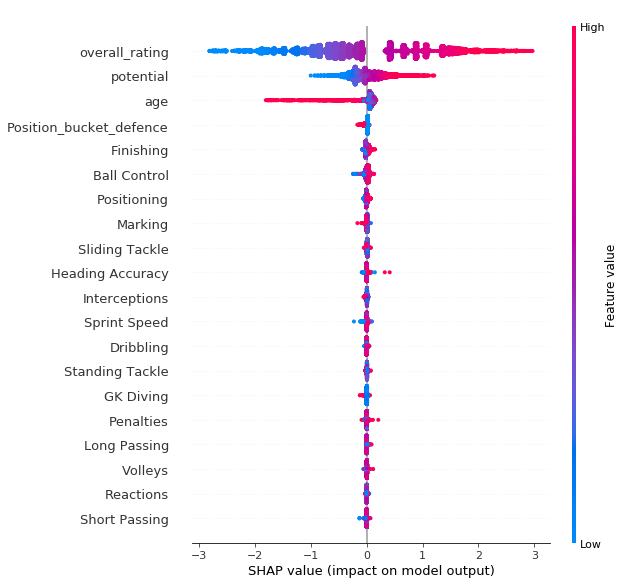

In [162]:
shap.summary_plot(shap_values,X_train_shap)

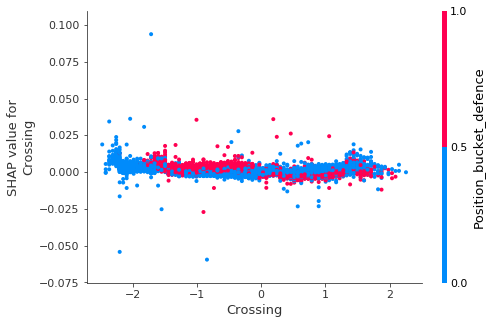

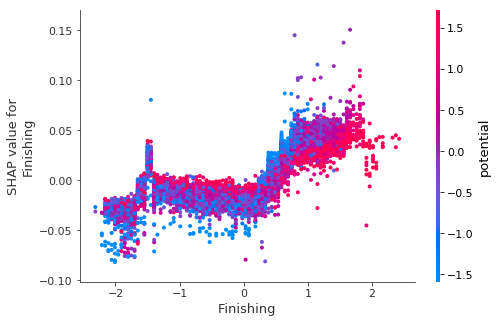

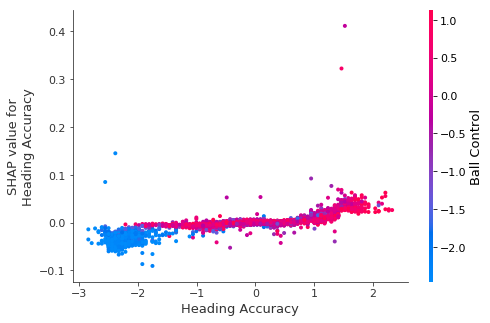

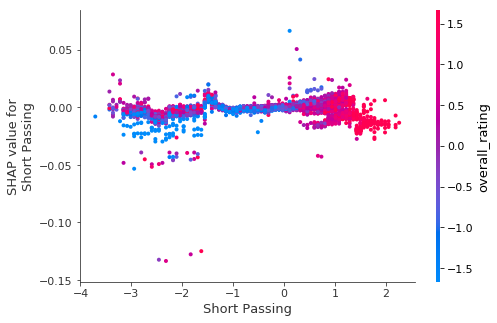

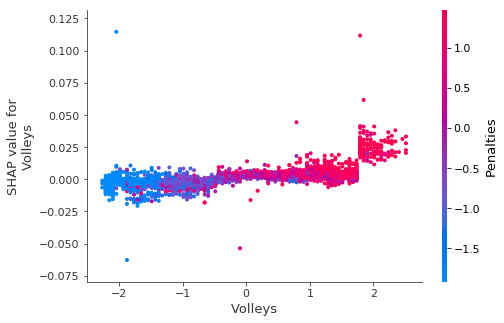

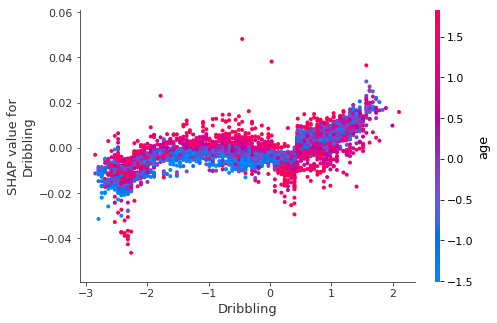

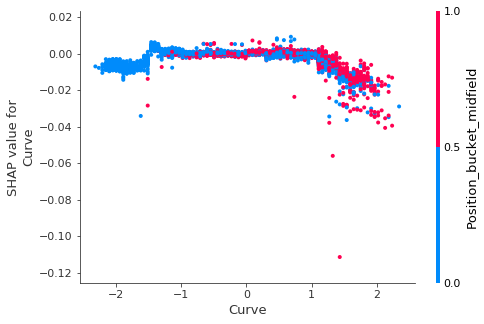

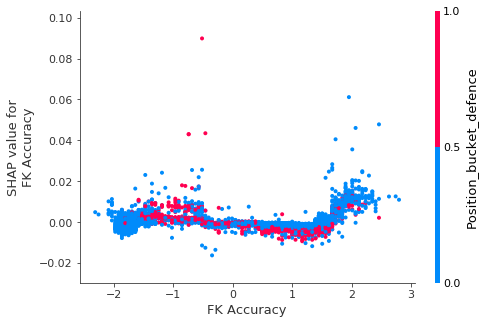

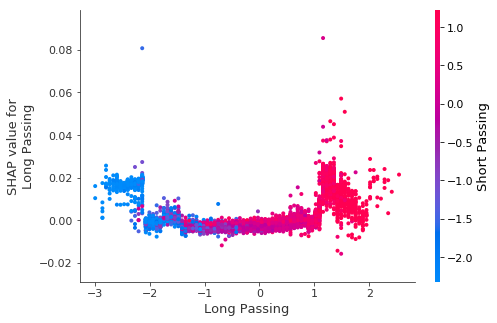

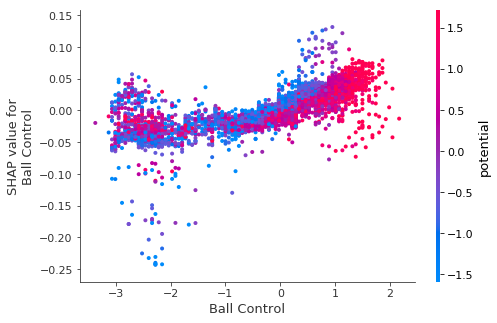

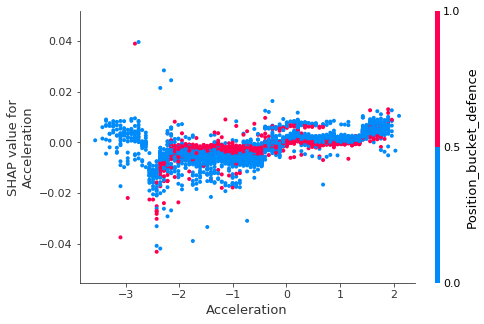

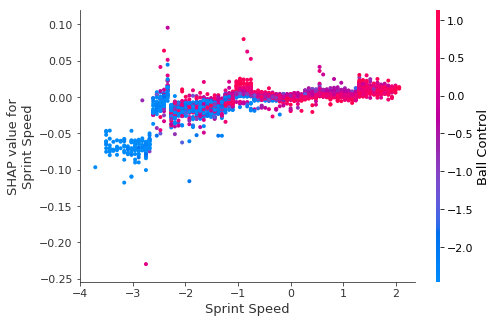

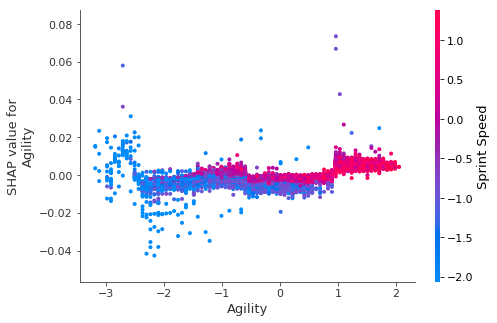

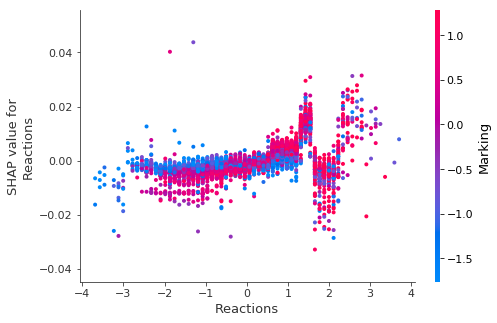

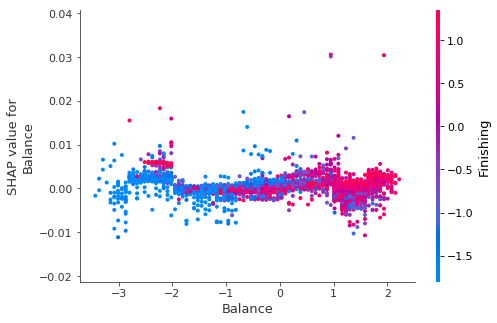

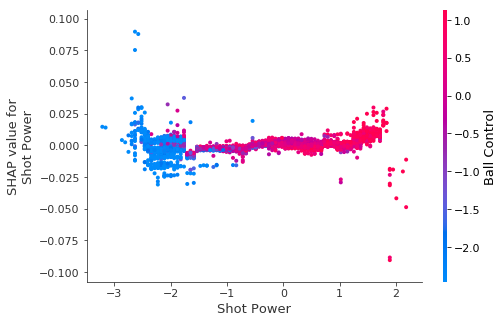

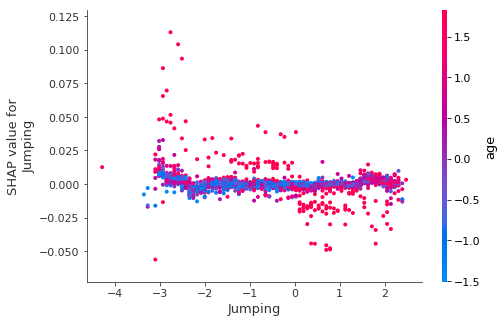

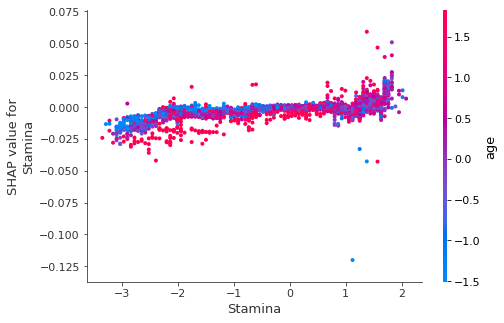

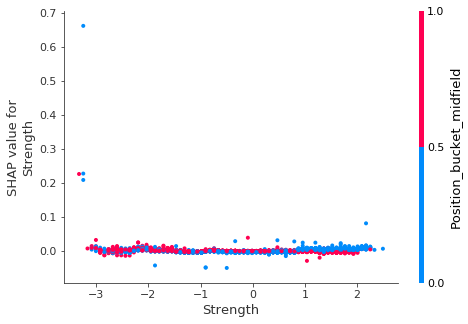

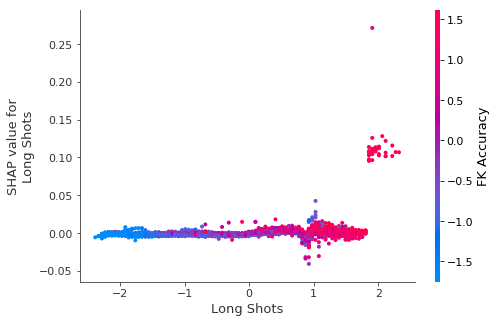

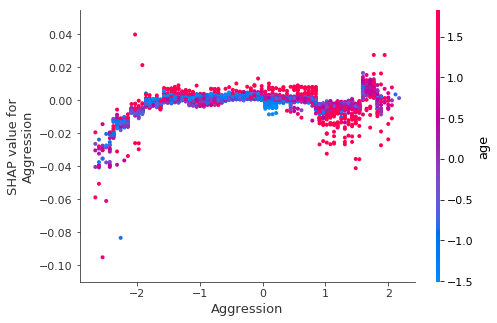

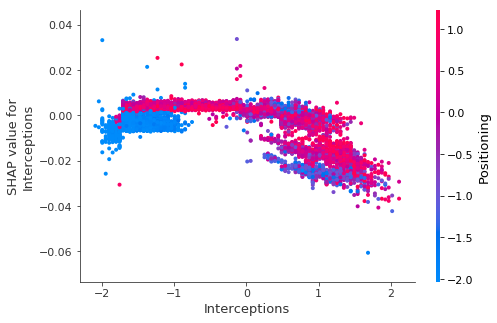

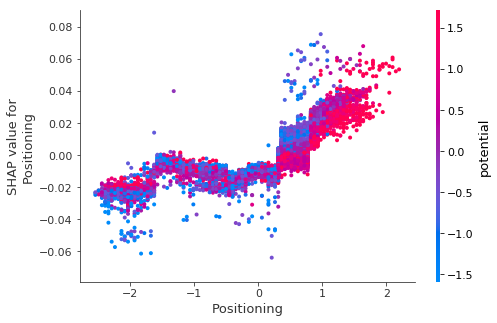

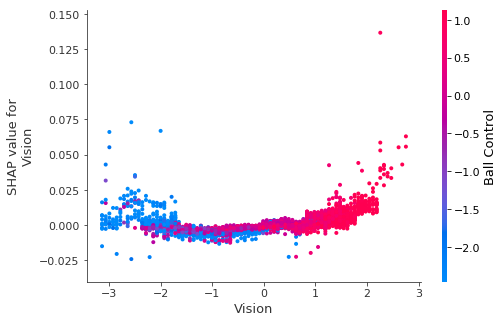

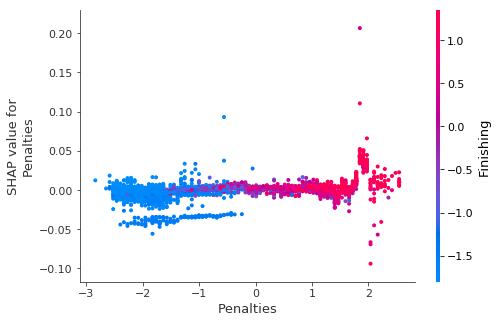

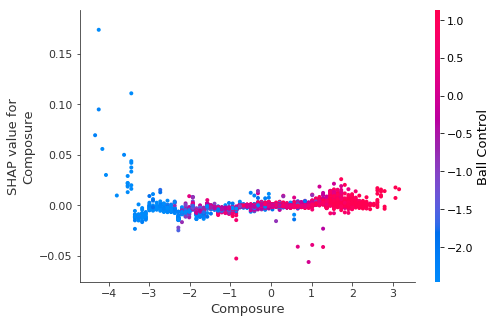

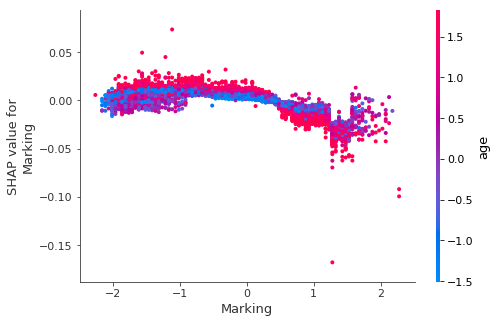

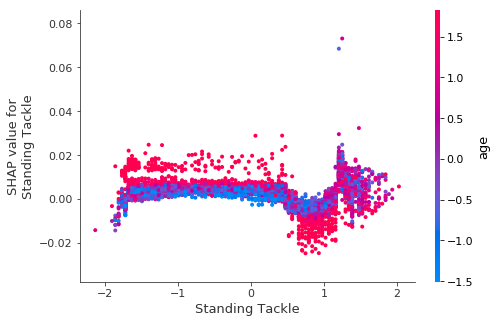

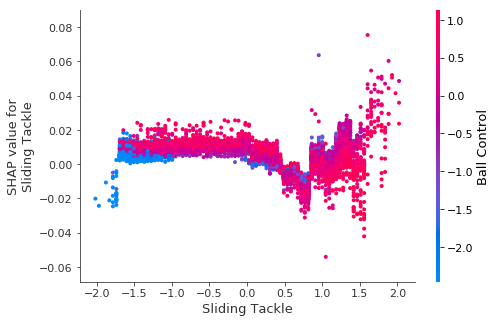

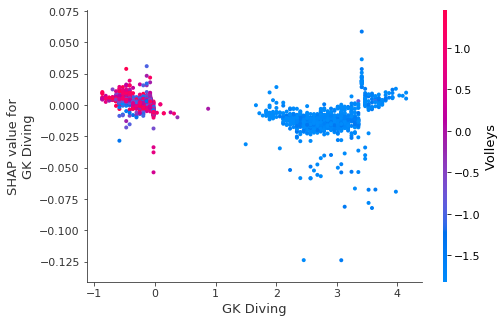

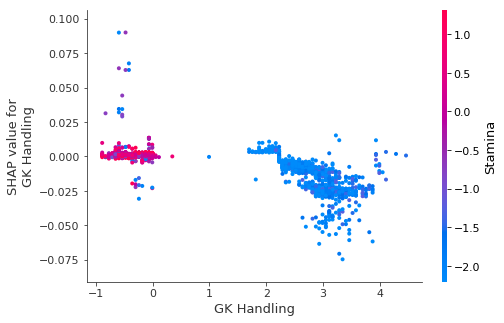

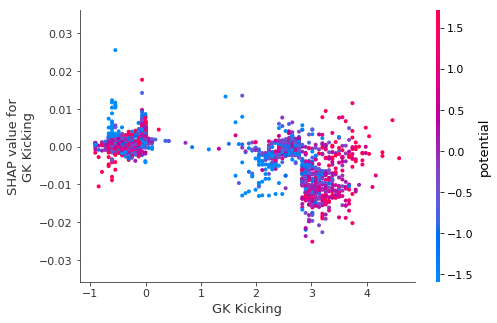

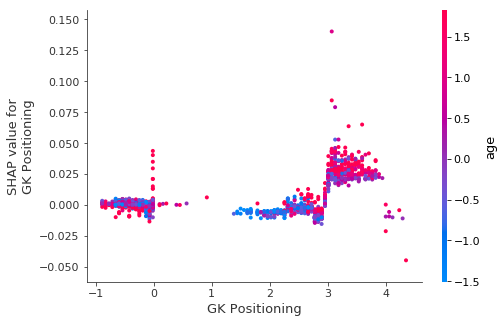

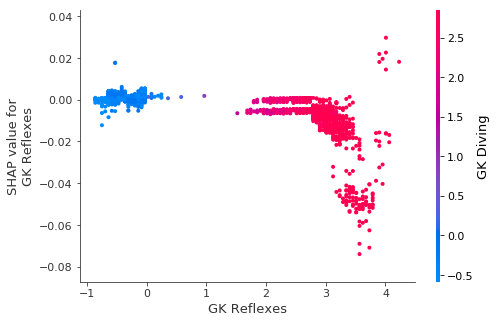

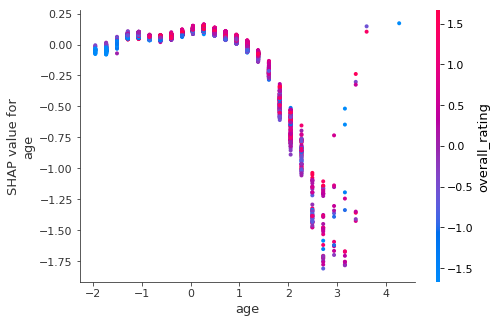

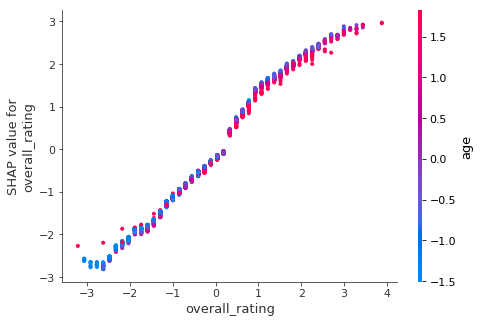

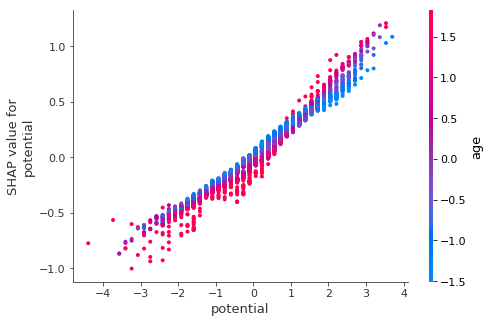

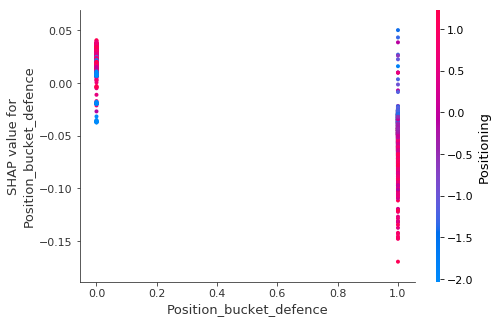

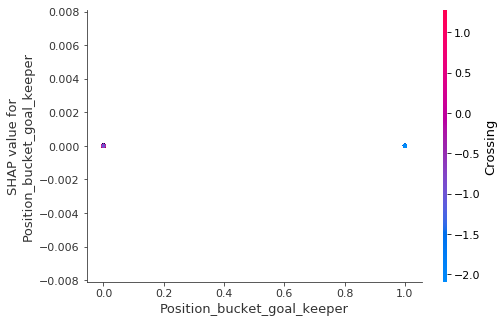

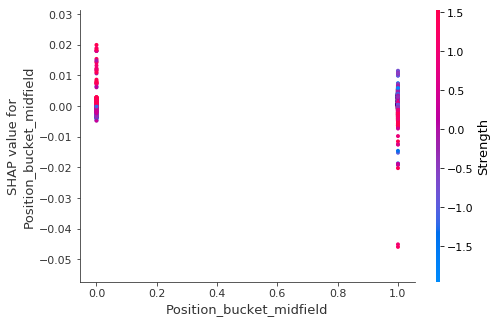

In [165]:
for name in X_train_shap.columns:
    shap.dependence_plot(name, shap_values, X_train_shap)

In [167]:
shap.force_plot(explainer.expected_value[0],
                shap_values[0][:1000,:], X_train_shap.iloc[:1000,:])

IndexError: invalid index to scalar variable.

## Simple supervised clustering

Clustering datapoints by their shap_values leads to groups relevant to the prediction task at hand (their market value)

In [171]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

shap_pca50 = PCA(n_components=12).fit_transform(shap_values[:1000,:])
shap_embedded = TSNE(n_components=2, perplexity=50).fit_transform(shap_values[:1000,:])

In [173]:
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MaxNLocator
cdict1 = {
    'red': ((0.0, 0.11764705882352941, 0.11764705882352941),
            (1.0, 0.9607843137254902, 0.9607843137254902)),

    'green': ((0.0, 0.5333333333333333, 0.5333333333333333),
              (1.0, 0.15294117647058825, 0.15294117647058825)),

    'blue': ((0.0, 0.8980392156862745, 0.8980392156862745),
             (1.0, 0.3411764705882353, 0.3411764705882353)),

    'alpha': ((0.0, 1, 1),
              (0.5, 1, 1),
              (1.0, 1, 1))
}  # #1E88E5 -> #ff0052
red_blue_solid = LinearSegmentedColormap('RedBlue', cdict1)

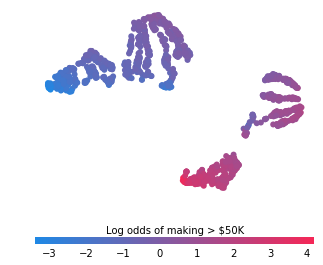

In [176]:


f = plt.figure(figsize=(5,5))
plt.scatter(shap_embedded[:,0],
           shap_embedded[:,1],
           c=shap_values[:1000,:].sum(1).astype(np.float64),
           linewidth=0, alpha=1., cmap=red_blue_solid)
cb = plt.colorbar(label="Log odds of making > $50K", aspect=40, orientation="horizontal")
cb.set_alpha(1)
cb.draw_all()
cb.outline.set_linewidth(0)
cb.ax.tick_params('x', length=0)
cb.ax.xaxis.set_label_position('top')
plt.gca().axis("off")
plt.show()



## Feature engineering

We have seen with the above that the most predictive featuresa are (unsurprisingly) overall rating and potential. Age is also a key factor - for decreasing the expected value. The other playing attributes, while having some effect, don't seem to have significant effects on the model. These features could still be useful by combining them into more general categories e.g. attacking skills, defending skills, goal keeping skills etc.

In [177]:
ATTRIBUTES

['Crossing',
 'Finishing',
 'Heading Accuracy',
 'Short Passing',
 'Volleys',
 'Dribbling',
 'Curve',
 'FK Accuracy',
 'Long Passing',
 'Ball Control',
 'Acceleration',
 'Sprint Speed',
 'Agility',
 'Reactions',
 'Balance',
 'Shot Power',
 'Jumping',
 'Stamina',
 'Strength',
 'Long Shots',
 'Aggression',
 'Interceptions',
 'Positioning',
 'Vision',
 'Penalties',
 'Composure',
 'Marking',
 'Standing Tackle',
 'Sliding Tackle',
 'GK Diving',
 'GK Handling',
 'GK Kicking',
 'GK Positioning',
 'GK Reflexes']

In [190]:
skills_dict = {
    'goal_keeping_skills': ['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes'],
    'defending_skills': ['Strength', 'Interceptions', 'Positioning', 'Standing Tackle', 'Sliding Tackle', 'Jumping',
                         'Aggression','Marking'],
    'attacking_skills': ['Crossing', 'Finishing', 'Heading Accuracy', 'Short Passing', 'Volleys', 'Dribbling',
                         'Curve', 'FK Accuracy', 'Long Passing', 'Ball Control', 'Acceleration', 'Sprint Speed',
                         'Agility', 'Reactions', 'Balance', 'Shot Power', 'Long Shots','Penalties', 'Composure',
                        'Stamina','Vision']
}

In [216]:
for skill_cat, skills in skills_dict.items():
    df[skill_cat] = df[skills].mean(axis=1)
    
df_fe = df[list(skills_dict.keys())+['age','overall_rating','potential','Position_bucket','value_clean_log']]

df_fe.head()

,goal_keeping_skills,defending_skills,attacking_skills,age,overall_rating,potential,Position_bucket,value_clean_log
0,9.0,74.000,54.238095,19,77,88,defence,16.380460
1,10.0,73.875,72.809524,20,75,84,midfield,16.118096
2,10.6,68.125,58.619048,20,74,85,defence,15.955577
3,72.6,30.375,34.380952,20,73,87,goal_keeper,15.830414
4,9.2,69.000,80.428571,27,87,87,midfield,17.757092


In [217]:
#load in raw data again
def make_fe_data_set(skills_dict=skills_dict):
    
    #load raw data
    raw_df = pd.read_csv("data/1. processed/data_clean.csv")    
    df = raw_df.loc[raw_df['value_clean']!=0].copy() #delete rows with 0 in value_clean column

    #select sensible features
    df = df[ATTRIBUTES + ['age','overall_rating','potential','Position','value_clean']]
    
    #log transform value_clean attribute
    df['target'] = np.log(df['value_clean'])
    del df['value_clean']
    
        
    #drop missing position datapoints
    df = df.loc[df['Position'].notnull()].copy()
    
    #create player position buckets
    df['Position_bucket'] = df['Position'].apply(bucket_positions) 
    del df['Position']
    
    #combine attribute features
    for skill_cat, skills in skills_dict.items():
        df[skill_cat] = df[skills].mean(axis=1)
    
    #new_df without individual attributes
    df = df[list(skills_dict.keys())+['age','overall_rating','potential','Position_bucket','target']]
    
    
    #make sure no missing data
    assert df.isnull().sum().sum() == 0
    
    #shuffle the datafrmae
    df_shuffled = shuffle(df, random_state=0)

    #create train and test split
    return train_test_split(df_shuffled.iloc[:,:-1],
                            df_shuffled.iloc[:,-1],
                            test_size=0.33,
                            random_state=0)
    
    

In [229]:
X_train_fe,X_test_fe,y_train_fe,y_test_fe = make_fe_data_set()

In [232]:
numeric_features = X_train_fe.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train_fe.select_dtypes(include=['object']).columns


#apply transformations to numerical and categroical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', nominal_categorical_transformer, categorical_features)])

In [235]:
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgbrg', XGBRegressor())])


param_grid = {
    "xgbrg__n_estimators": [10, 50, 100, 500, 1000],
    "xgbrg__learning_rate": [0.1, 0.5, 1]
}

fit_params = {"xgbrg__eval_metric":"logloss"}


grid = GridSearchCV(xgb_pipeline, cv=5, 
                    param_grid=param_grid,
                    fit_params=fit_params,
                    n_jobs=-1,verbose=10)
grid.fit(X_train_fe,y_train_fe) 

C:\Users\westj\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:643: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   44.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  1.2min finished
C:\Users\westj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\westj\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int64, float64 were all conve

[18:23:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), Index(['goal_keeping_skills', 'de...lpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1))]),
       fit_params={'xgbrg__eval_metric': 'logloss'}, iid='warn', n_jobs=-1,
       param_grid={'xgbrg__n_estimators': [10, 50, 100, 500, 1000], 'xgbrg__learning_rate': [0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=10)

In [236]:
xgb_fe_predict = grid.predict(X_test_fe)

xgb_fe_RMSE = np.sqrt(mean_squared_error(y_test_fe, xgb_fe_predict))

print(grid.best_params_)

print(xgb_fe_RMSE)

C:\Users\westj\Anaconda3\lib\site-packages\sklearn\pipeline.py:451: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


{'xgbrg__learning_rate': 0.1, 'xgbrg__n_estimators': 1000}
0.08445344439922325


In [245]:
X_train_fe_shap = X_train_fe.copy()
X_train_fe_shap = pd.get_dummies(X_train_fe_shap,drop_first=True)

scaler = StandardScaler()
X_train_fe_shap[numeric_features] = scaler.fit_transform(X_train_fe_shap[numeric_features])

xgb_fe_best_model = XGBRegressor(learning_rate = 0.1,
                              n_estimators = 1000).fit(X_train_fe_shap,y_train_fe)

C:\Users\westj\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\westj\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\westj\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[17:26:19] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


WANT TO ADD A LIFT CHART

In [246]:
#pipelines objects are not supported by shap, therefore will re

explainer = shap.TreeExplainer(xgb_fe_best_model)
shap_values = explainer.shap_values(X_train_fe_shap)

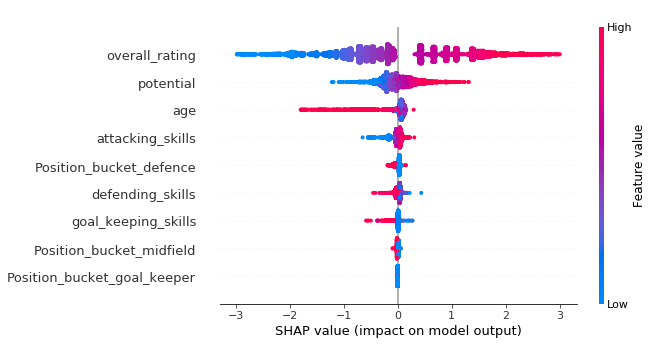

In [247]:
shap.summary_plot(shap_values,X_train_fe_shap)

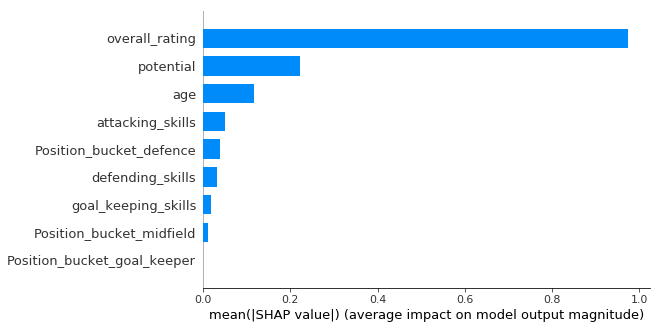

In [258]:
shap.summary_plot(shap_values, X_train_fe_shap, plot_type="bar")

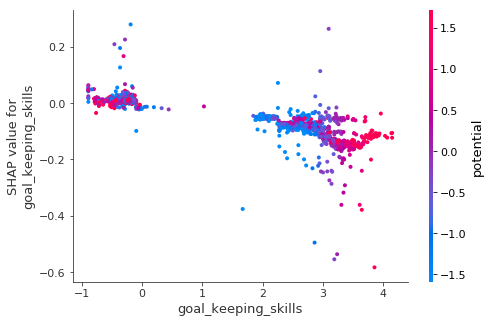

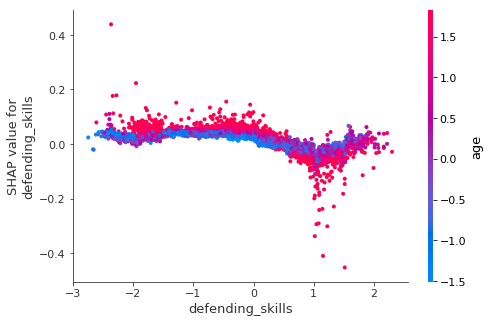

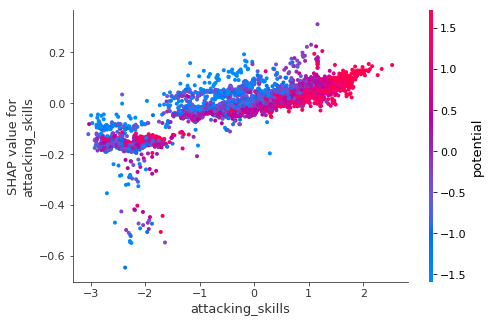

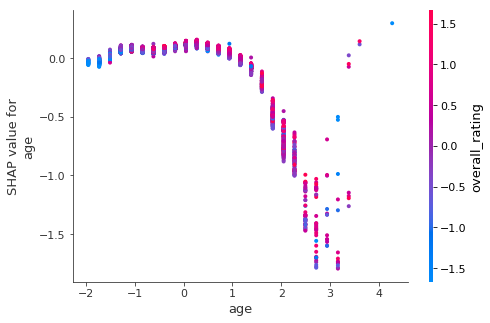

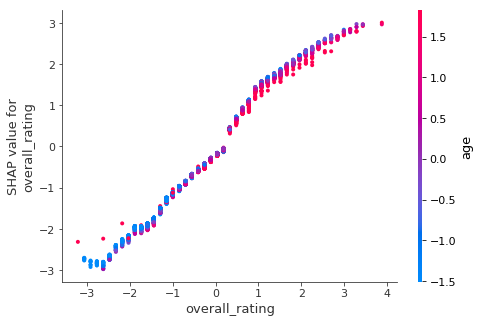

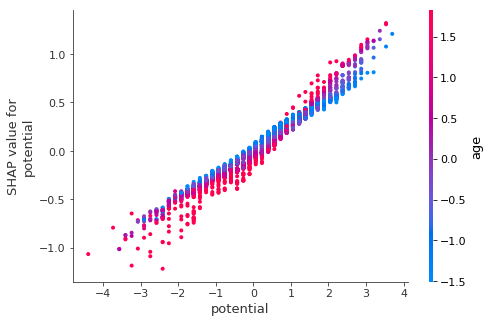

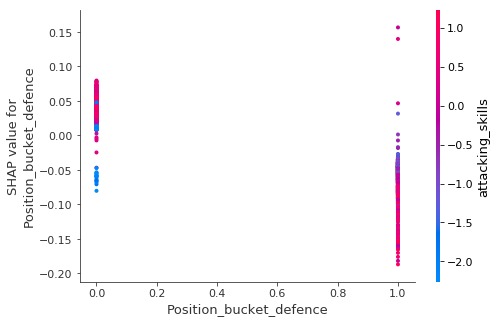

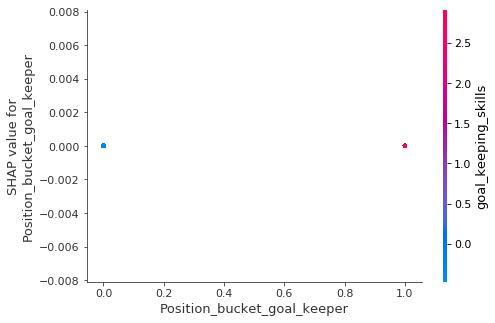

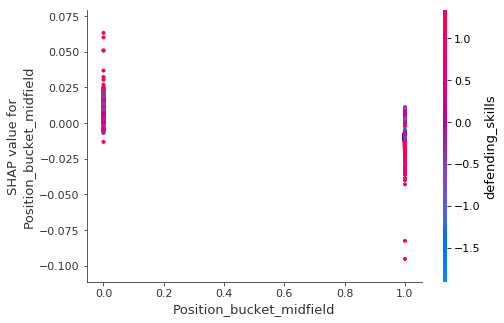

In [261]:
for name in X_train_fe_shap.columns:
    shap.dependence_plot(name, shap_values, X_train_fe_shap)

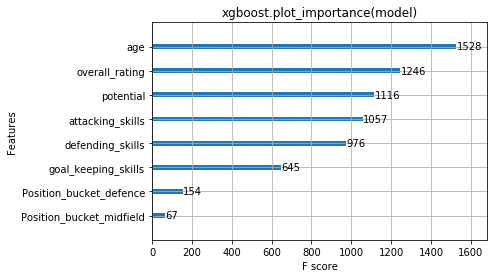

In [257]:
xgboost.plot_importance(xgb_fe_best_model)
plt.title("xgboost.plot_importance(model)")
plt.show()



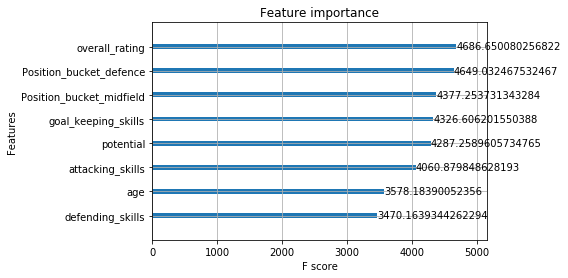

In [254]:
xgboost.plot_importance(xgb_fe_best_model,importance_type="cover")

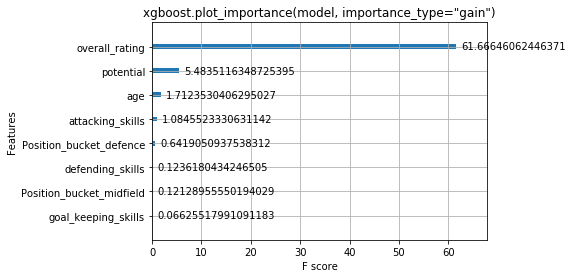

In [256]:
xgboost.plot_importance(xgb_fe_best_model, importance_type="gain")
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()



## Dealing with outliers - need to do this after train-test split

In [ ]:
# Function to Detection Outlier on one-dimentional datasets.
def find_anomalies(data,CUT_OFF=3):
    
    anomalies = []
    
    data_std, data_mean = np.std(data), np.mean(data)
    anomaly_cut_off = data_std * CUT_OFF
    
    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off

    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies

anomalies = find_anomalies(df['value_clean_log'])

anomolies_index = df.loc[df['value_clean_log'].isin(anomalies)].index
print("Players with log values outside 3 std")
raw_df.iloc[anomolies_index][['name']]

There are only 18 players with values outside three std of the mean. I will drop these from the data.

In [ ]:
#drop original target variable 'value_clean' 
df.drop(columns=['value_clean'])

df.shape

__Outlier detection__

calculate Cook's distances for linear regression [link](http://mpastell.com/2013/04/19/python_regression/)

## Future Work

Get data from different timeperiods e.g. from 5 years ago and now to create a model which predicts the value of the player (or percentage increase in value) in 5 years time.


Other modelling techniques - could have used PCA analysis however this would have made the model difficult to interpret.